In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import make_scorer, fbeta_score
from corner import corner

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from WISE_tools import plot_confusion_matrix, plot_completeness_contamination

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'CommonName_y', 'Class',
        'CoarseClass', 'IsBinary', 'WISE_Designation_x', 'N_obs', 'W1chi2',
        'W1chi2red', 'W1logchi2red', 'W1_MAD', 'W1_EWM', 'W1_logEWM', 'W2chi2',
        'W2chi2red', 'W2logchi2red', 'W2_MAD', 'W2_EWM', 'W2_logEWM',
        'W1-W2chi2', 'W1-W2chi2red', 'W1-W2logchi2red', 'W1-W2_MAD',
        'W1-W2_EWM', 'W1-W2_logEWM', 'WISE_Designation_y', 'N_visits',
        'W1_Nzeroe

In [3]:
training_indices = np.array([c not in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

In [4]:
#training data
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1logchi2red','W1_logEWM','W1_Nzeroes',
                   'W1_log_meanDt', 'W1_log_stdDt','W2logchi2red','W2_logEWM','W2_Nzeroes', 'W2_log_meanDt',
                   'W2_log_stdDt','W1-W2logchi2red','W1-W2_logEWM','W1-W2_Nzeroes','W1-W2_log_meanDt','W1-W2_log_stdDt']]
#replace infs with nans
X.replace([np.inf, -np.inf], np.nan,inplace=True)

y = training_data['Class'].values
y_c = training_data['CoarseClass'].values

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=0)

#scale, and then use an IterativeImputer to replace NaNs with interpolated values
scaler=StandardScaler()
imputer = IterativeImputer(max_iter=100, random_state=0)
X_train_scale = imputer.fit_transform(scaler.fit_transform(X_train))
X_test_scale = imputer.transform(scaler.transform(X_test))

/Users/carina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [5]:
svc = SVC(class_weight='balanced')

param_grid = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1,1,10,1.0/X_train_scale.shape[1]]), "C":[0.01,0.1,1,10,100]},
              {"kernel": ["linear"], "C":[0.01,0.1,1,10,100]}]

scorer = 'balanced_accuracy'

grid = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=10, error_score=-1e10,scoring=scorer)
grid.fit(X_train_scale, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:    7.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   15.8s finished
/Users/carina/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed

GridSearchCV(cv=5, error_score=-10000000000.0,
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': array([ 0.01      ,  0.1       ,  1.        , 10.        ,  0.04166667]),
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=10)

In [6]:
best_svc = grid.best_estimator_
print(grid.best_params_)

{'C': 0.01, 'kernel': 'linear'}


In [27]:
best_svc.fit(X_train_scale,y_train)
y_check = best_svc.predict(X_test_scale)

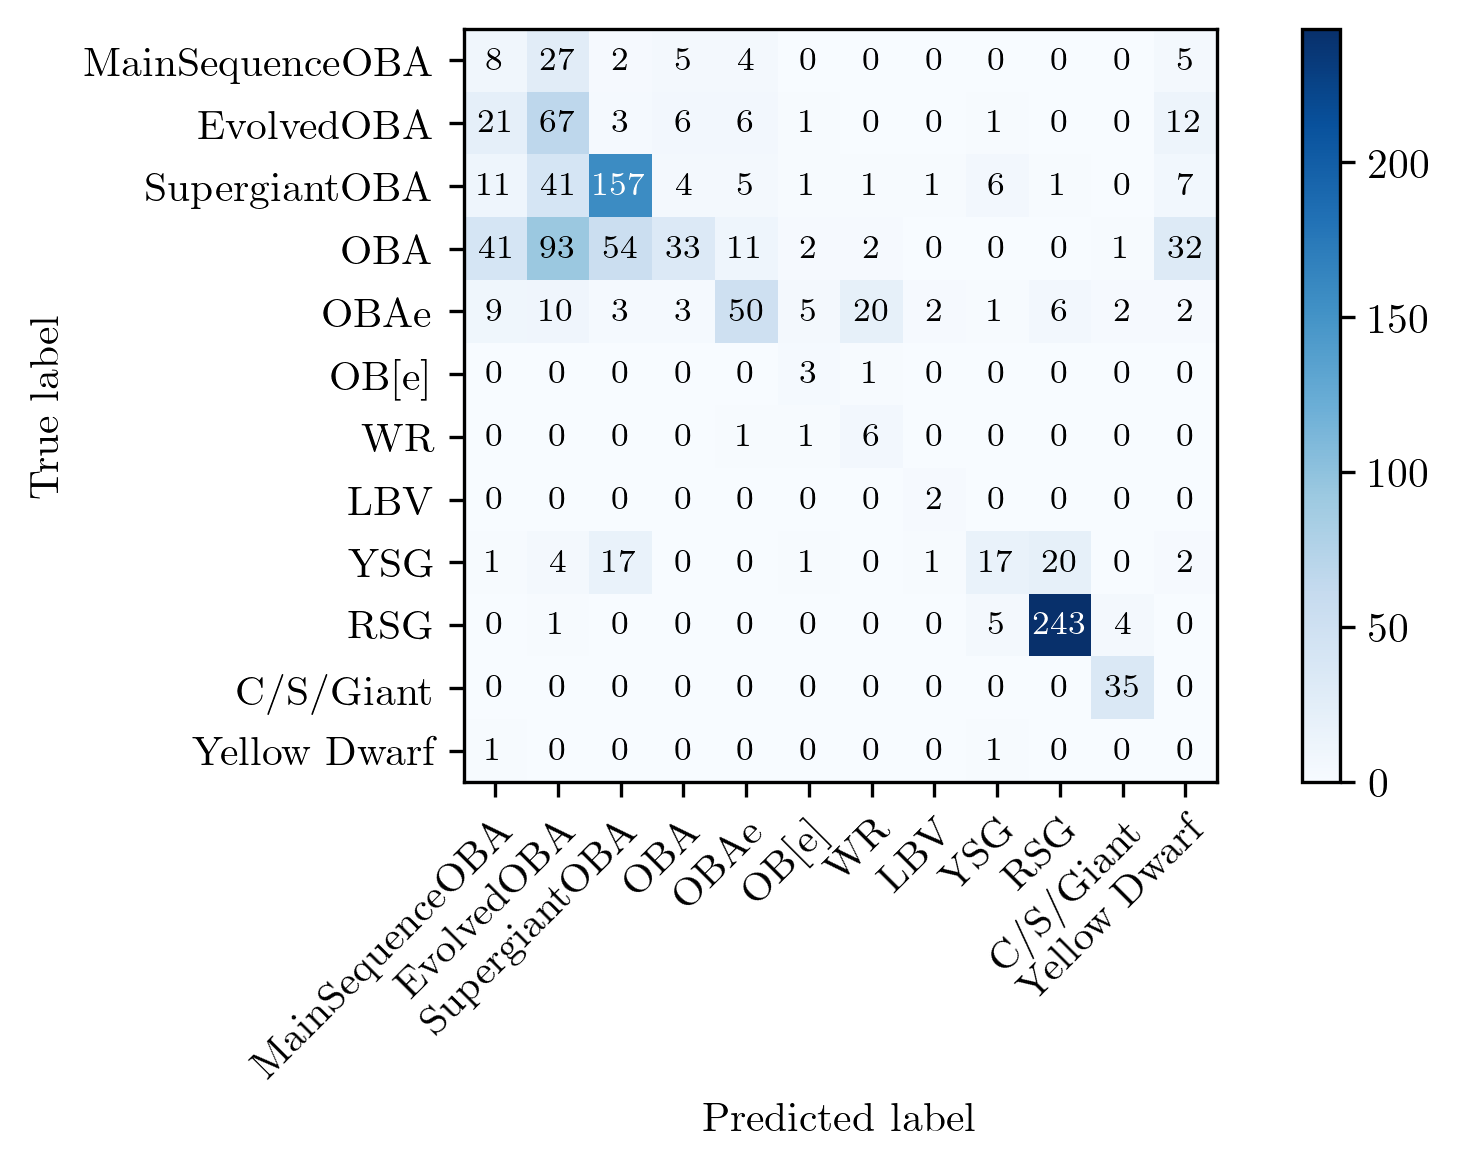

In [8]:
classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant','Yellow Dwarf']

fig,ax = plot_confusion_matrix(y_test, y_check, classes=classes, normalize=False);
fig.dpi = 300
ax.set_title('')
plt.tight_layout()
plt.savefig('../plots/raw_matrix_SVC.pdf');

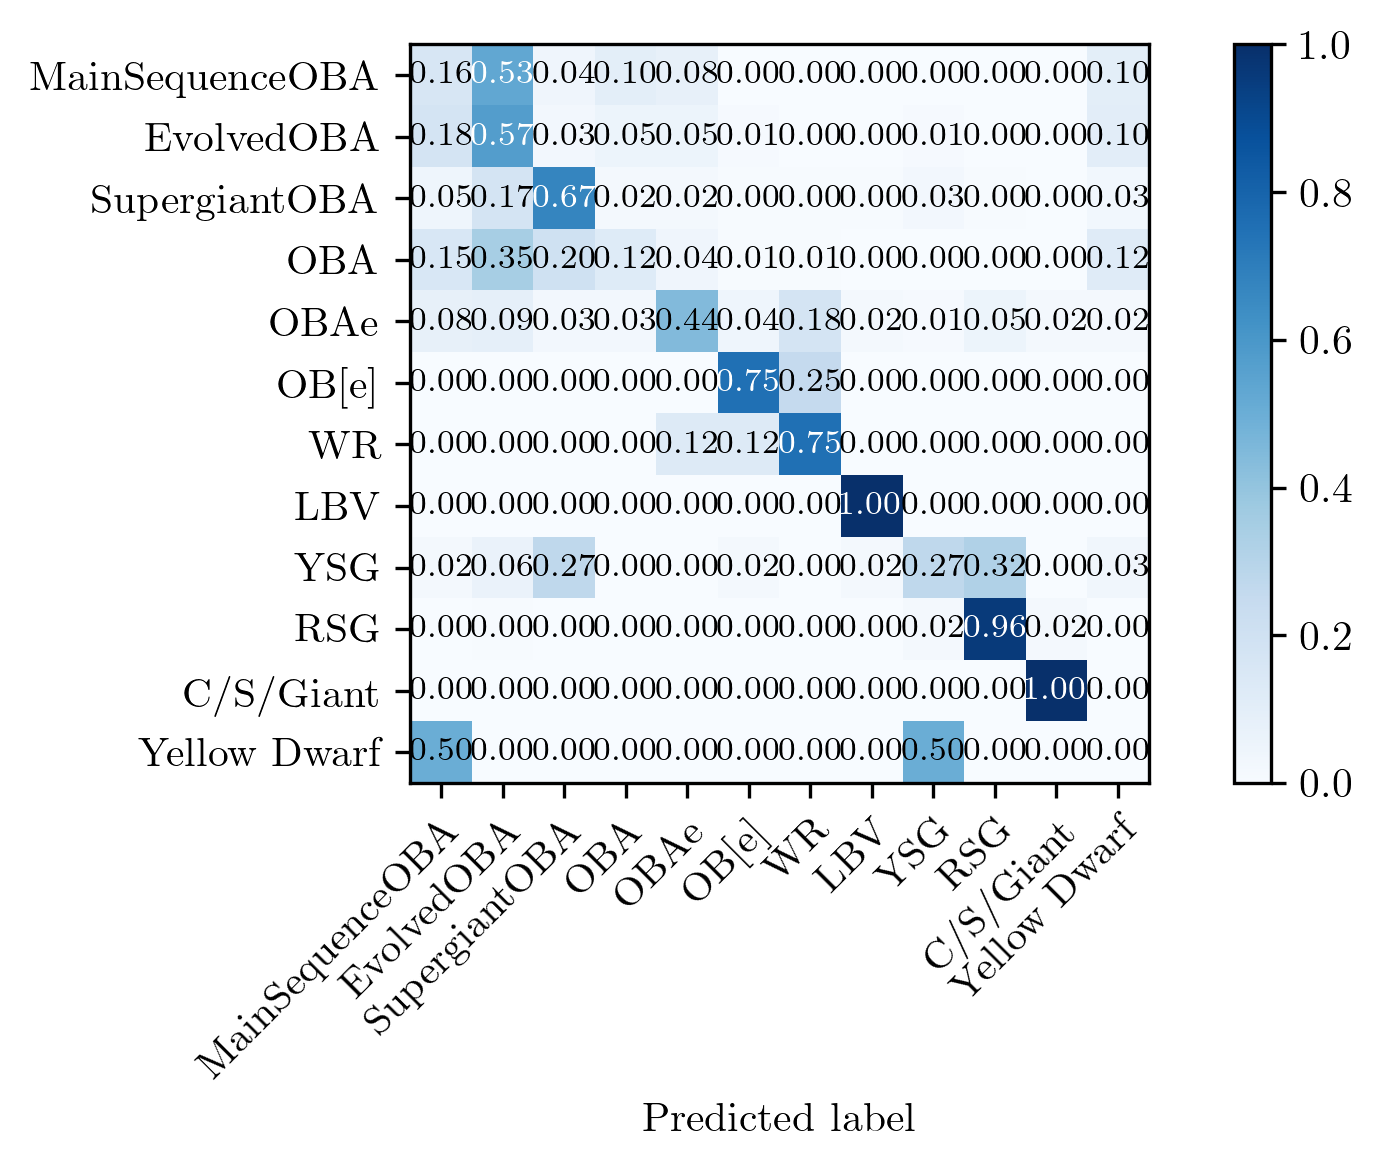

In [9]:
fig,ax = plot_confusion_matrix(y_test, y_check, classes=classes, normalize=True);
fig.dpi = 300
ax.set_title('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('../plots/confusion_SVC.pdf');

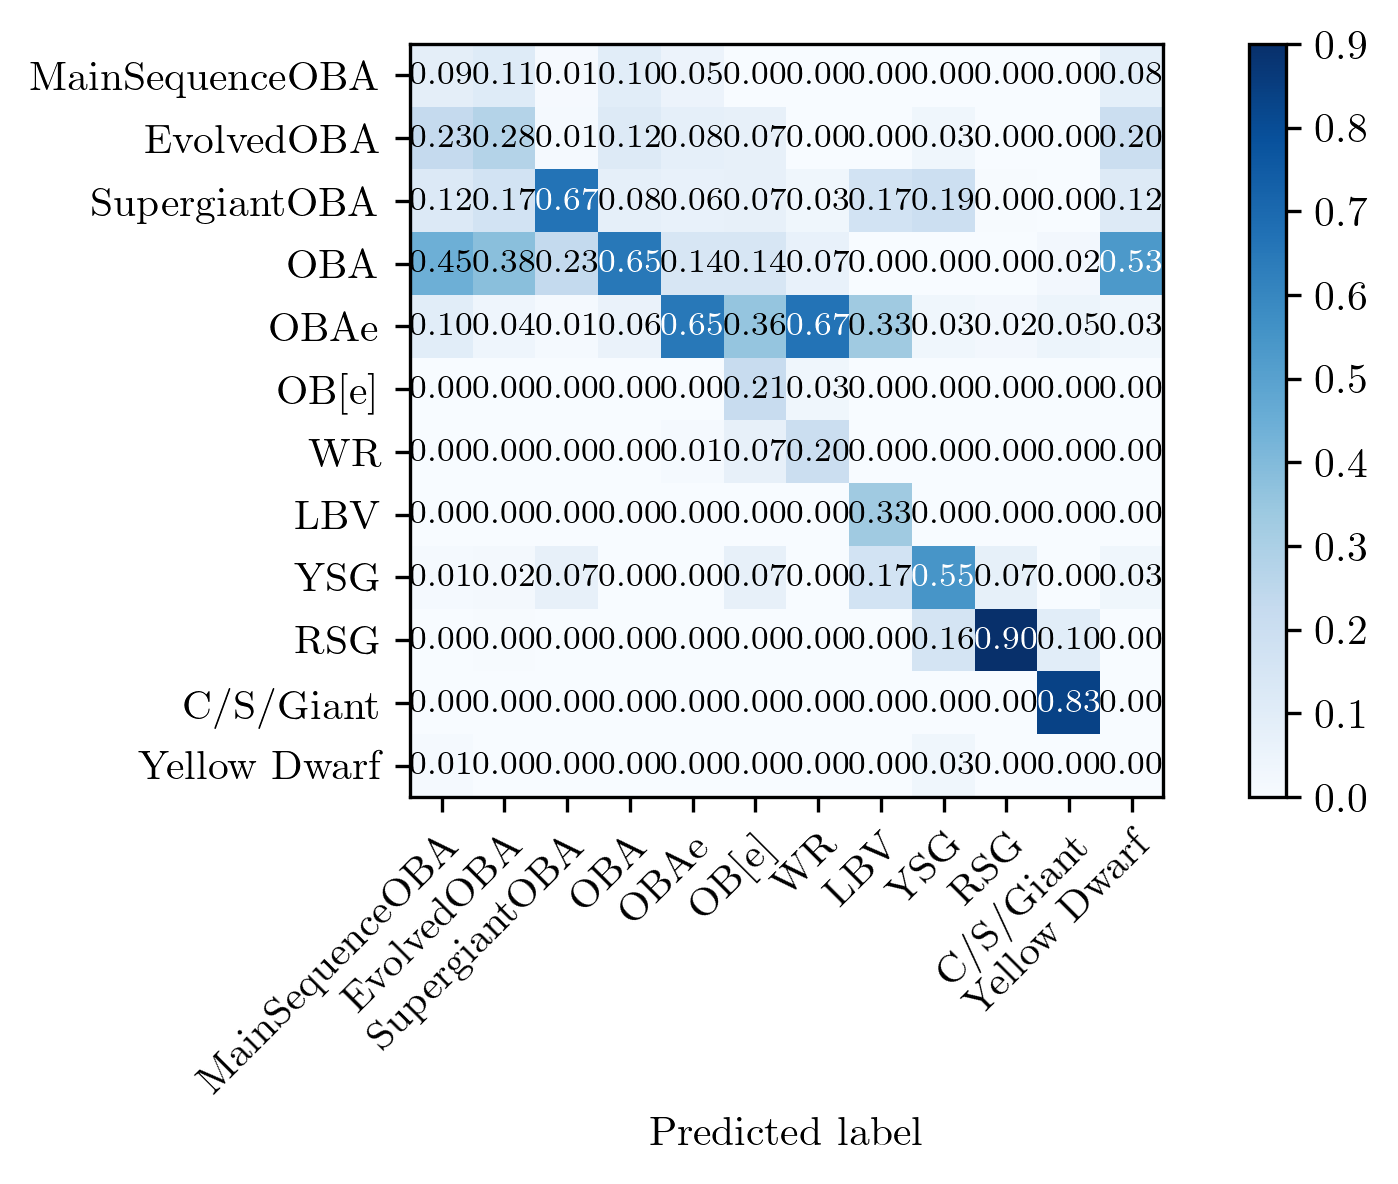

In [10]:
fig,ax = plot_confusion_matrix(y_test, y_check, classes=classes, normalize=True, normalize_axis=0);
fig.dpi = 300
ax.set_title('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('../plots/efficiency_SVC.pdf');

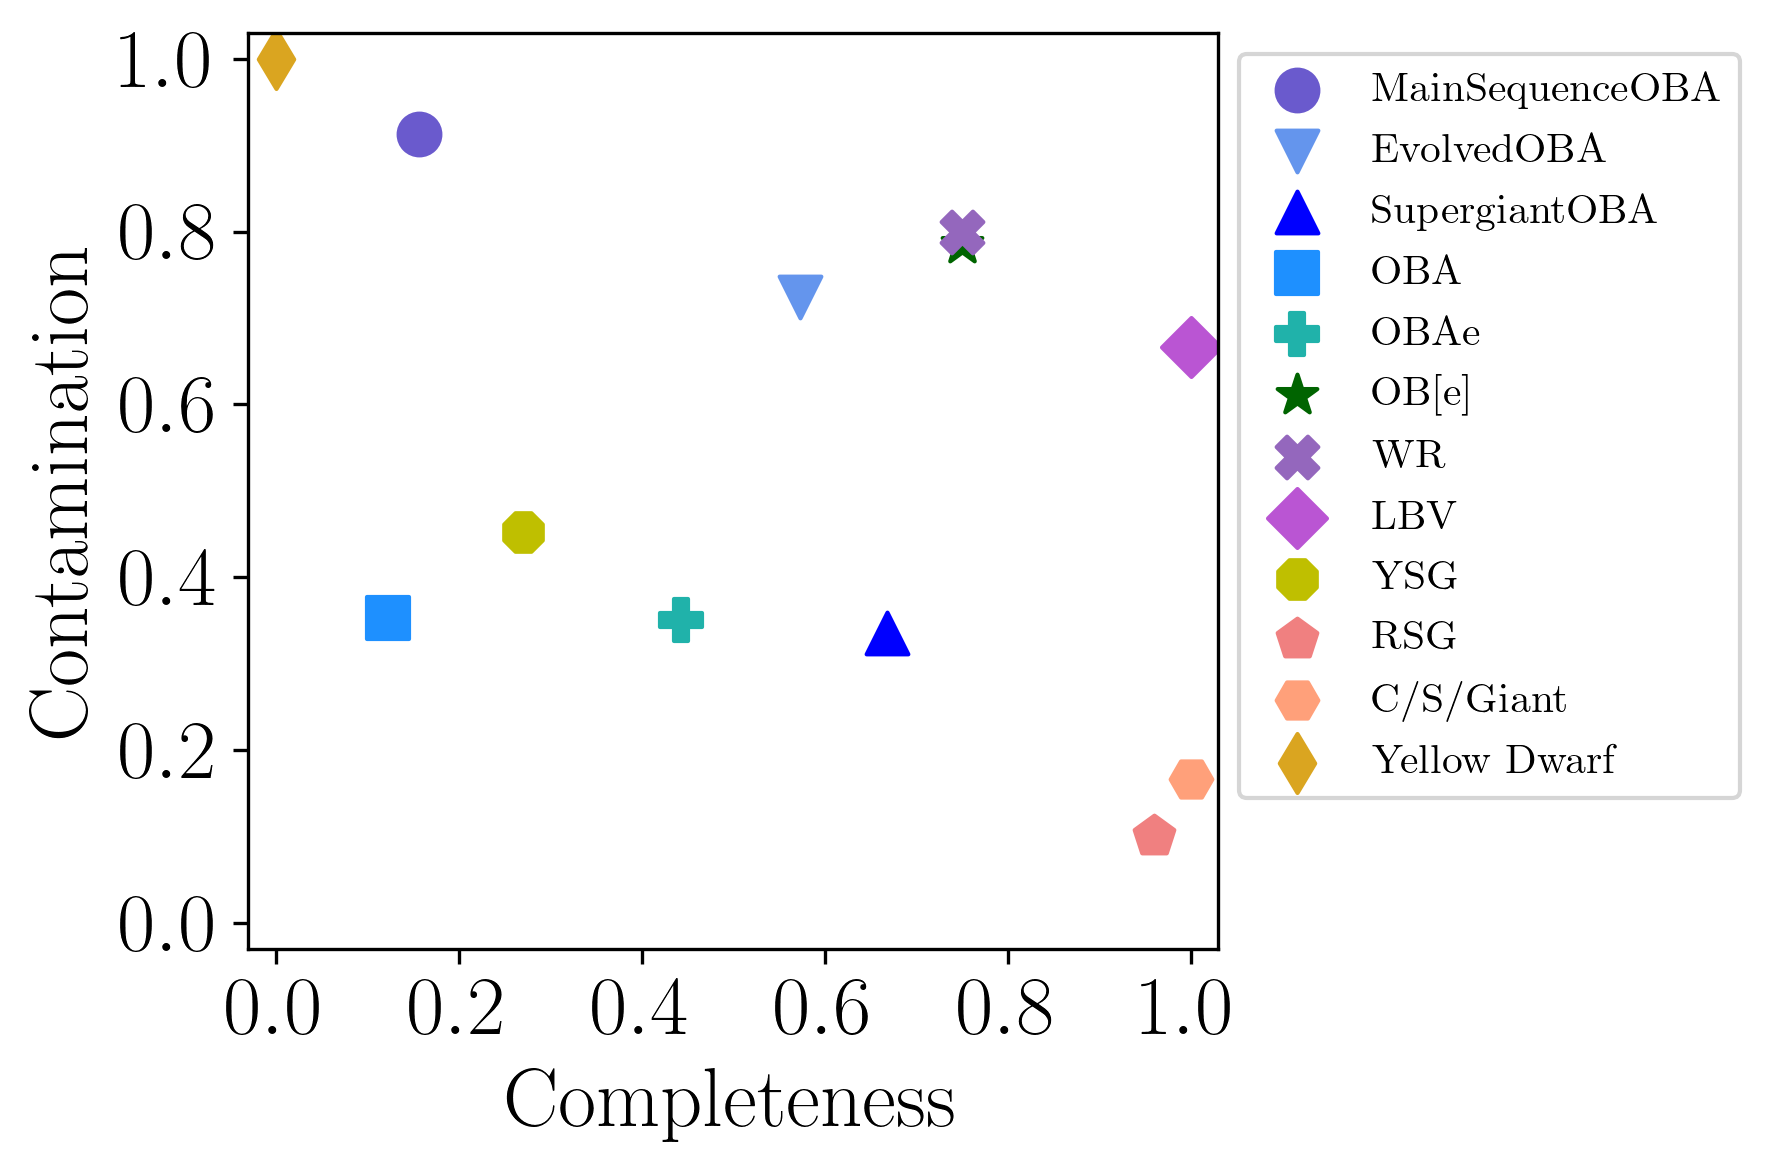

In [11]:
m_dict = {'MainSequenceOBA':'o','EvolvedOBA':'v','SupergiantOBA':'^','OBA':'s',
          'OBAe':'P','OB[e]':'*','WR':'X','LBV':'D','YSG':'8','RSG':'p','C/S/Giant':'H','Yellow Dwarf':'d'}
c_dict = {'MainSequenceOBA':'slateblue','EvolvedOBA':'cornflowerblue','SupergiantOBA':'b',
          'OBA':'dodgerblue','OBAe':'lightseagreen','OB[e]':'darkgreen','WR':'C4',
          'LBV':'mediumorchid','YSG':'y','RSG':'lightcoral','C/S/Giant':'lightsalmon','Yellow Dwarf':'goldenrod'}
fig,ax = plot_completeness_contamination(y_test, y_check, classes=classes,c_dict=c_dict,m_dict=m_dict,s=100)
fig.dpi=300
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlim(-0.03,1.03)
ax.set_ylim(-0.03,1.03)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
fig.tight_layout()
plt.savefig('../plots/completeness_contamination_SVC.pdf')

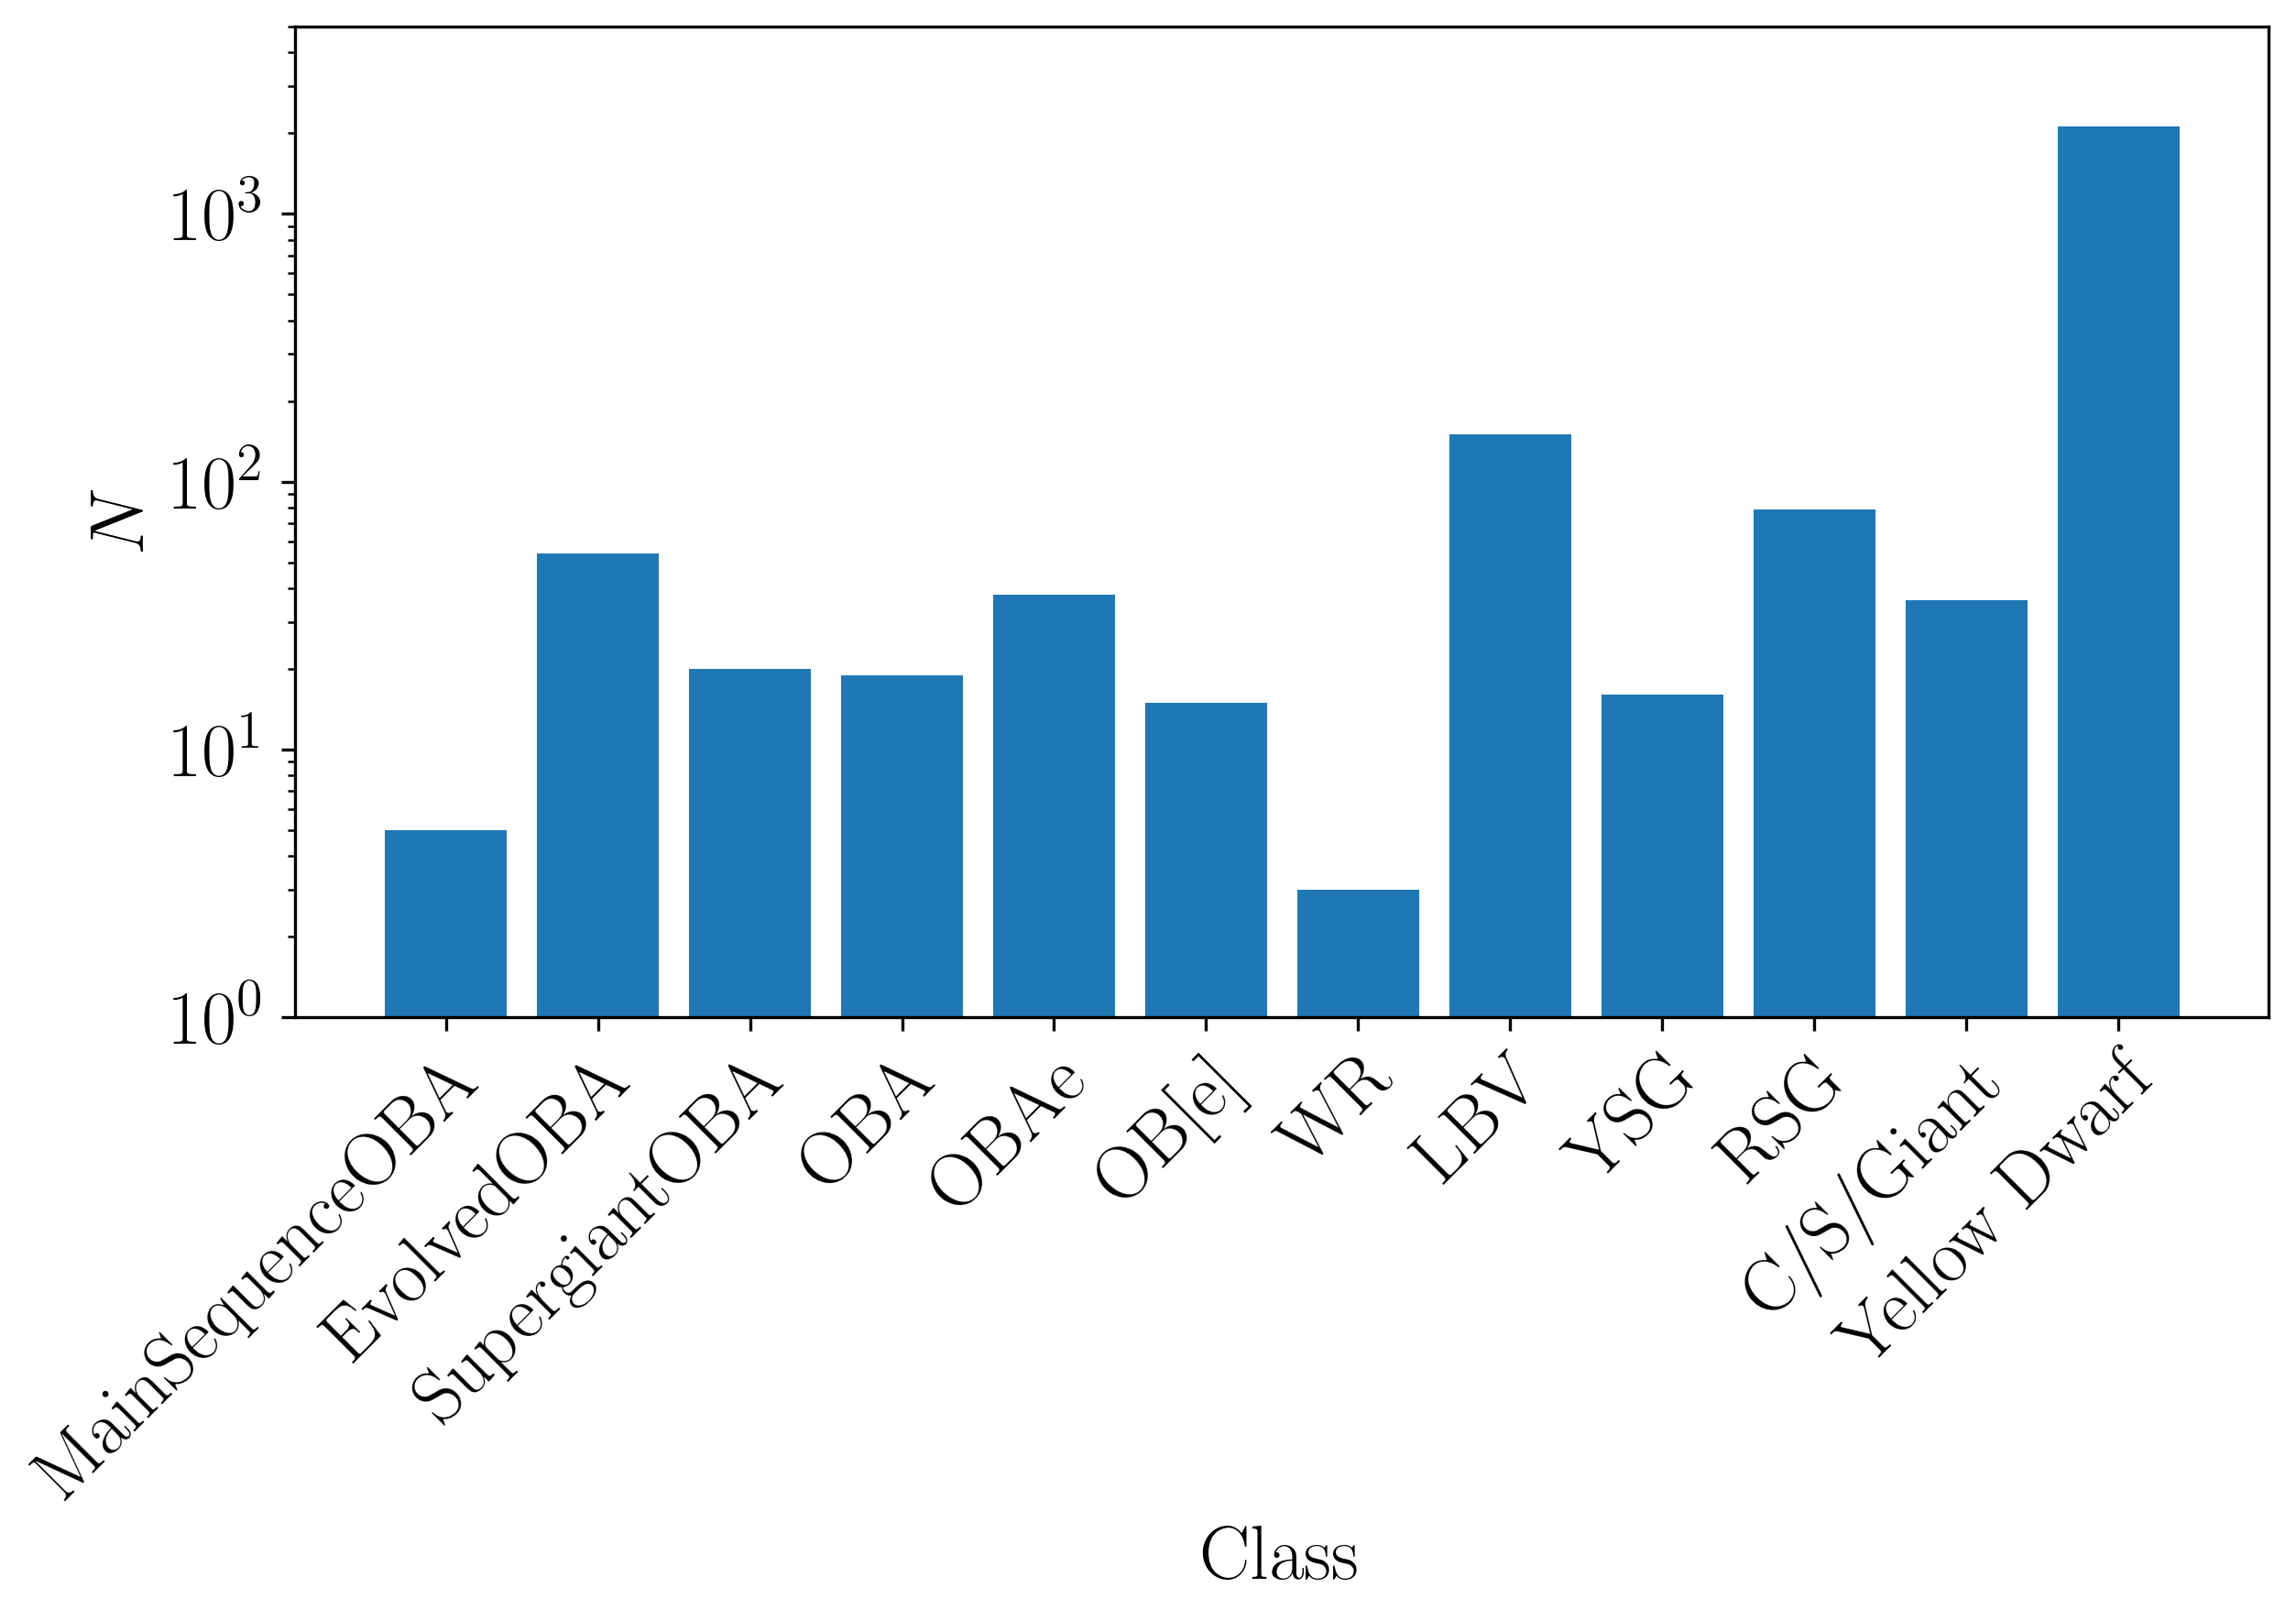

In [28]:
unknown_indices = [c in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class']]
unknowns = joined[unknown_indices].fillna(value=0).reset_index()
unknowns_data = unknowns[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W1_EWM','W1_Nzeroes',
                   'W1_meanDt', 'W1_stdDt','W2chi2red','W2_EWM','W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2chi2red','W1-W2_EWM','W1-W2_Nzeroes','W1-W2_meanDt','W1-W2_stdDt']]
X_unknown = imputer.transform(scaler.transform(unknowns_data))

unknown_classes = best_svc.predict(X_unknown)
num_output = []
for pred_class in classes:
    num = len(unknown_classes[unknown_classes == pred_class])
    num_output.append(num)
    
plt.figure(dpi=300,figsize=(8.5,6))
plt.bar(np.arange(len(classes)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(classes)),labels=classes,rotation=45,ha="right",
             rotation_mode="anchor")
plt.xlabel('Class',fontsize=20)
plt.ylabel('$N$',fontsize=20)
plt.ylim(1,5000)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/unknown_labels_SVC.pdf')

In [30]:
for i,row in unknowns[unknown_classes == 'C/S/Giant'].reset_index().iterrows():
    print(i)
    print(row['ra'],row['dec'],row['CommonName_x'],row['SimbadOType'])

0
266.894817476808 -36.62412104905254 TYC 7389-1923-1 Star
1
268.69775471040407 -38.948442806017795 WISEJ175447.46-385654.3 0
2
273.91475148041513 -29.36066688334123 WISEJ181539.53-292138.4 0
3
275.11847878643243 -30.498614951982105 WISEJ182028.43-302954.9 0
4
86.31840420851877 -70.2121574299664 OGLE BRIGHT-LMC-MISC-349 Star
5
15.051374769702836 -72.15539949240704 SSTISAGEMA J010012.32-720919.4 Candidate_RSG*
6
96.70855191248279 -65.99738532846318 WISEJ062650.04-655950.5 0
7
80.10929225928369 -69.62558646259978 2MASS J05202623-6937320 LPV*
8
76.7420223952695 -69.14889067381938 WISEJ050658.07-690856.1 0
9
74.07733373109848 -70.27119776070755 WISEJ045618.53-701616.2 0
10
81.46444114678255 -70.02769945334838 WISEJ052551.46-700139.7 0
11
79.03091557443341 -69.68399967911185 LHA 120-S  94 LPV*
12
82.96283574078338 -69.98542592289928 WISEJ053151.10-695907.4 0
13
79.49190088482621 -69.43094921149671 WISEJ051758.05-692551.3 0
14
77.89799841143738 -69.2387184886216 2MASS J05113549-6914193 LPV*


# Can we back out feature importances?

In [31]:
column_dict = {i:col for i,col in zip(range(len(X.columns)),X.columns)}
index_dict = {col:i for i,col in zip(range(len(X.columns)),X.columns)}

test_svc = SVC(class_weight='balanced',kernel='rbf',C=10,gamma=0.01)

best_columns = np.array([])
best_indices = np.array([],dtype=int)
best_scores = np.array([])
best_stds = np.array([])

from tqdm.notebook import tqdm

while len(best_columns) != len(X.columns):
    test_indices = best_indices.copy() #current set of used indices
    trial_indices = []
    trial_scores = []
    trial_stds = []
    for i in tqdm(range(len(X.columns))): #for every feature
        if i not in best_indices: #if we aren't already using that feature...
            test_indices = np.append(test_indices,i) #add it to the list...
            subset_train = X_train_scale[:,test_indices] #grab the training data on those columns
            scores = cross_val_score(test_svc, subset_train, y_train, cv=5, scoring='balanced_accuracy', 
                                    n_jobs=-1, error_score=-1e10) #balanced accuracy over 5 stratefied folds
            
            trial_indices.append(i)
            trial_scores.append(scores.mean())
            trial_stds.append(scores.std())
            test_indices = test_indices[:-1]
    next_col = trial_indices[np.argmax(trial_scores)] #grab index that yielded the best accuracy
    best_columns = np.append(best_columns, column_dict[next_col])
    best_indices = np.append(best_indices, next_col)
    best_scores = np.append(best_scores, max(trial_scores))
    best_stds = np.append(best_stds, trial_stds[np.argmax(trial_scores)])
    print(len(best_columns))



1


KeyboardInterrupt: 

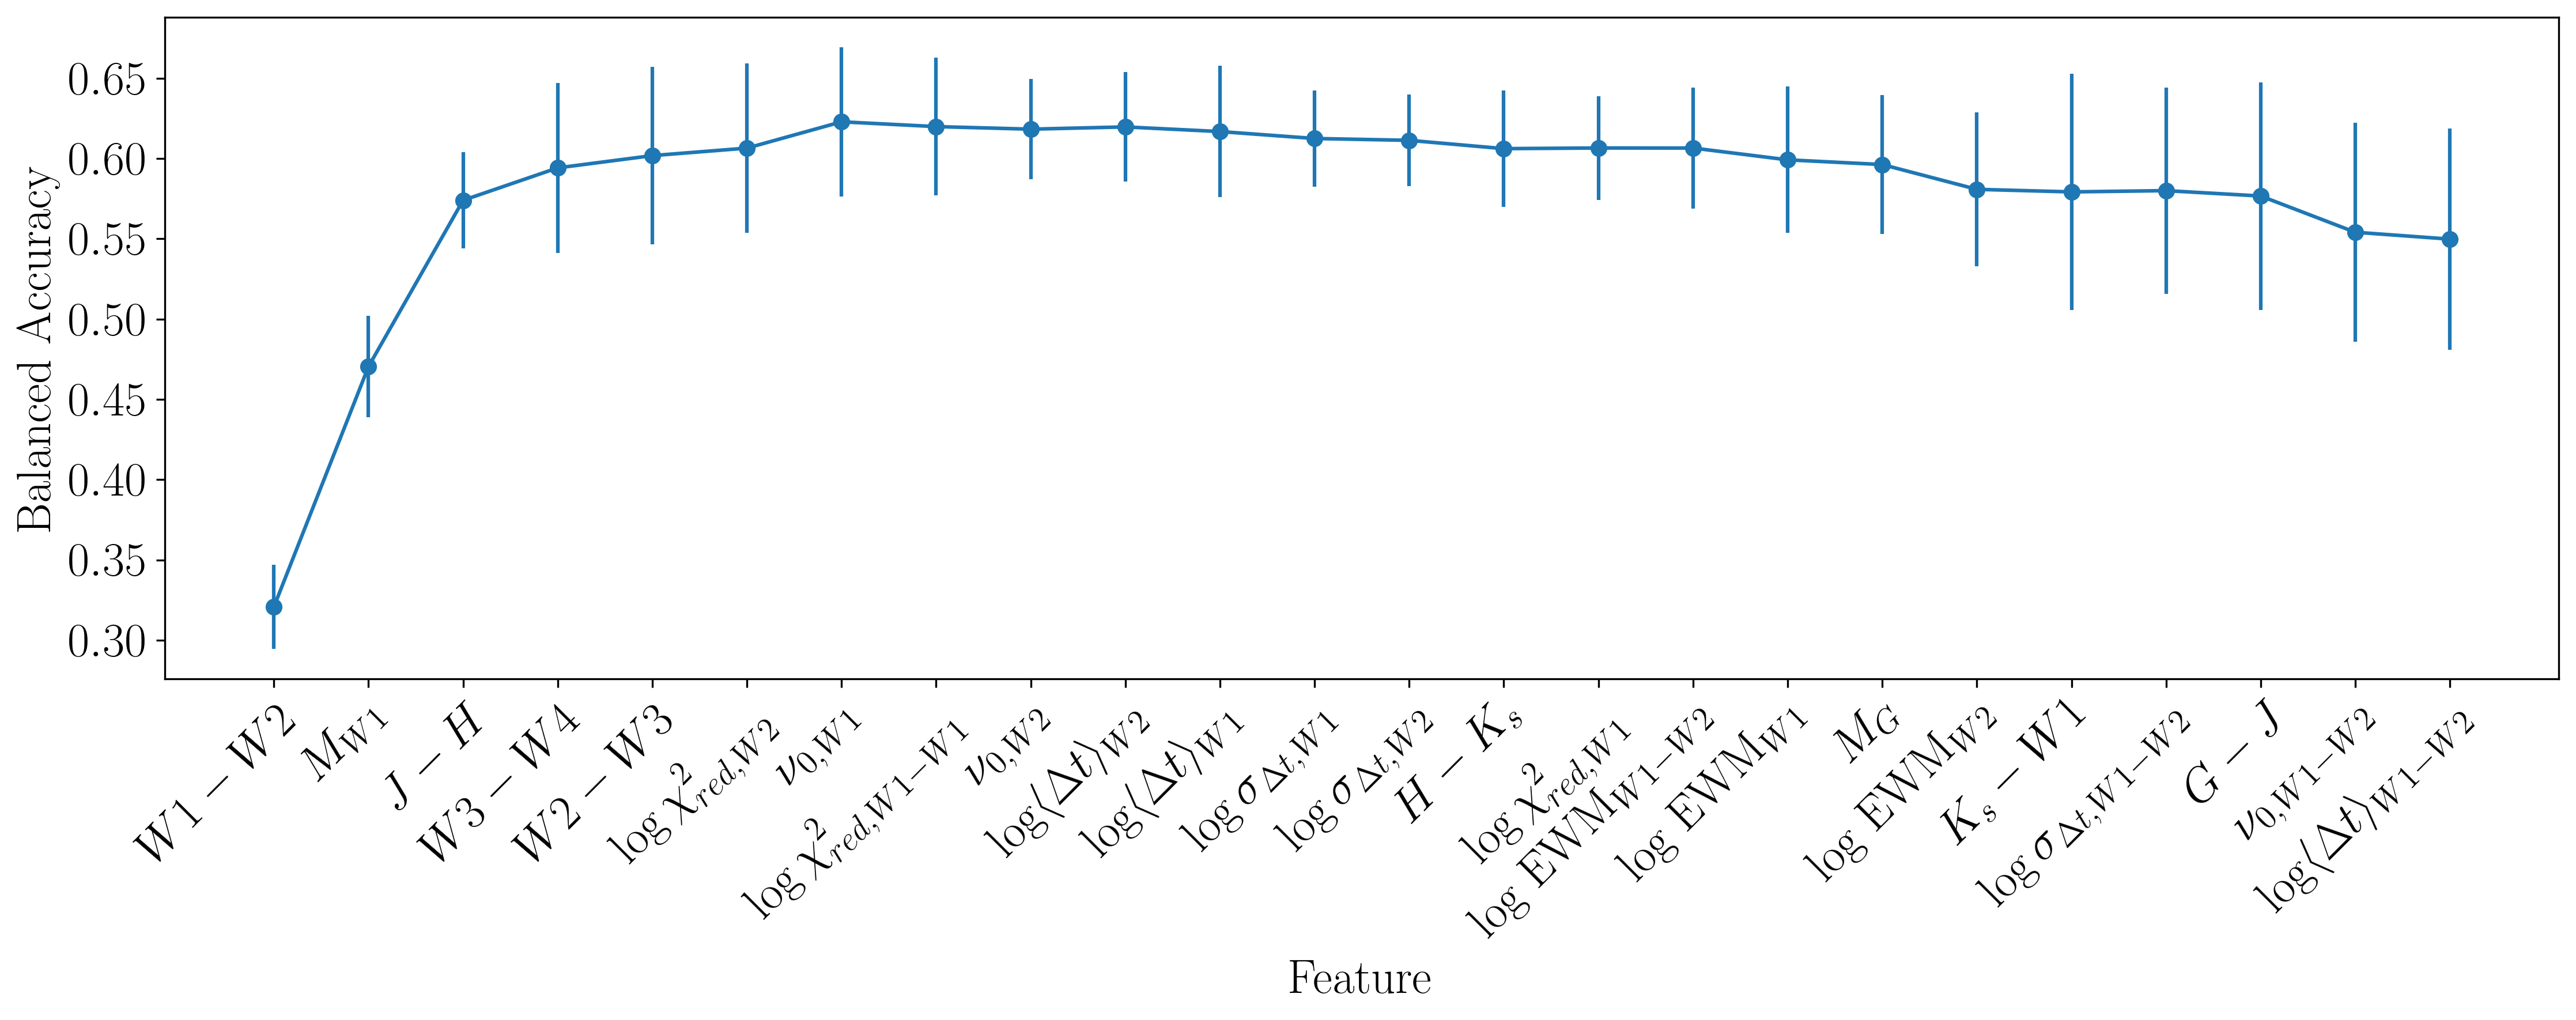

In [46]:
all_cols = ['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1logchi2red','W1_logEWM','W1_Nzeroes',
                   'W1_log_meanDt', 'W1_log_stdDt','W2logchi2red','W2_logEWM','W2_Nzeroes', 'W2_log_meanDt',
                   'W2_log_stdDt','W1-W2logchi2red','W1-W2_logEWM','W1-W2_Nzeroes','W1-W2_log_meanDt','W1-W2_log_stdDt']
var_names = ['$M_G$','$G-J$','$J-H$','$H-K_s$','$K_s-W1$','$W1-W2$','$W2-W3$','$W3-W4$','$M_{W1}$',r'$\log\chi^2_{red,W1}$',
             r'$\log$ EWM$_{W1}$',r'$\nu_{0,W1}$',r'$\log\langle \Delta t \rangle_{W1}$',
             r'$\log\sigma_{\Delta t,W1}$',r'$\log\chi^2_{red,W2}$',r'$\log$ EWM$_{W2}$',r'$\nu_{0,W2}$',
             r'$\log\langle \Delta t \rangle_{W2}$',r'$\log\sigma_{\Delta t,W2}$',r'$\log\chi^2_{red,W1-W1}$',
             r'$\log$ EWM$_{W1-W2}$',r'$\nu_{0,W1-W2}$',r'$\log\langle \Delta t \rangle_{W1-W2}$',
             r'$\log\sigma_{\Delta t,W1-W2}$','Class']
var_dict = {col:var for col,var in zip(all_cols,var_names)}

fig = plt.figure(dpi=300,figsize=(15,6))
ax=plt.gca()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.errorbar(np.arange(len(X.columns)),best_scores,yerr=best_stds,fmt='-o')
plt.xticks(ticks=np.arange(len(X.columns)),labels=[var_dict[col] for col in best_columns],rotation=45,ha="right",
             rotation_mode="anchor")
plt.xlabel('Feature')
plt.ylabel('Balanced Accuracy')
fig.tight_layout()
plt.savefig('../plots/feature_importance_svc.pdf')

In [16]:
first_seven = best_indices[:7]
X_first_seven = X_train_scale[:,first_seven]
X_first_seven_test = X_test_scale[:,first_seven]
test_svc.fit(X_first_seven,y_train)
y_check_seven = test_svc.predict(X_first_seven_test)

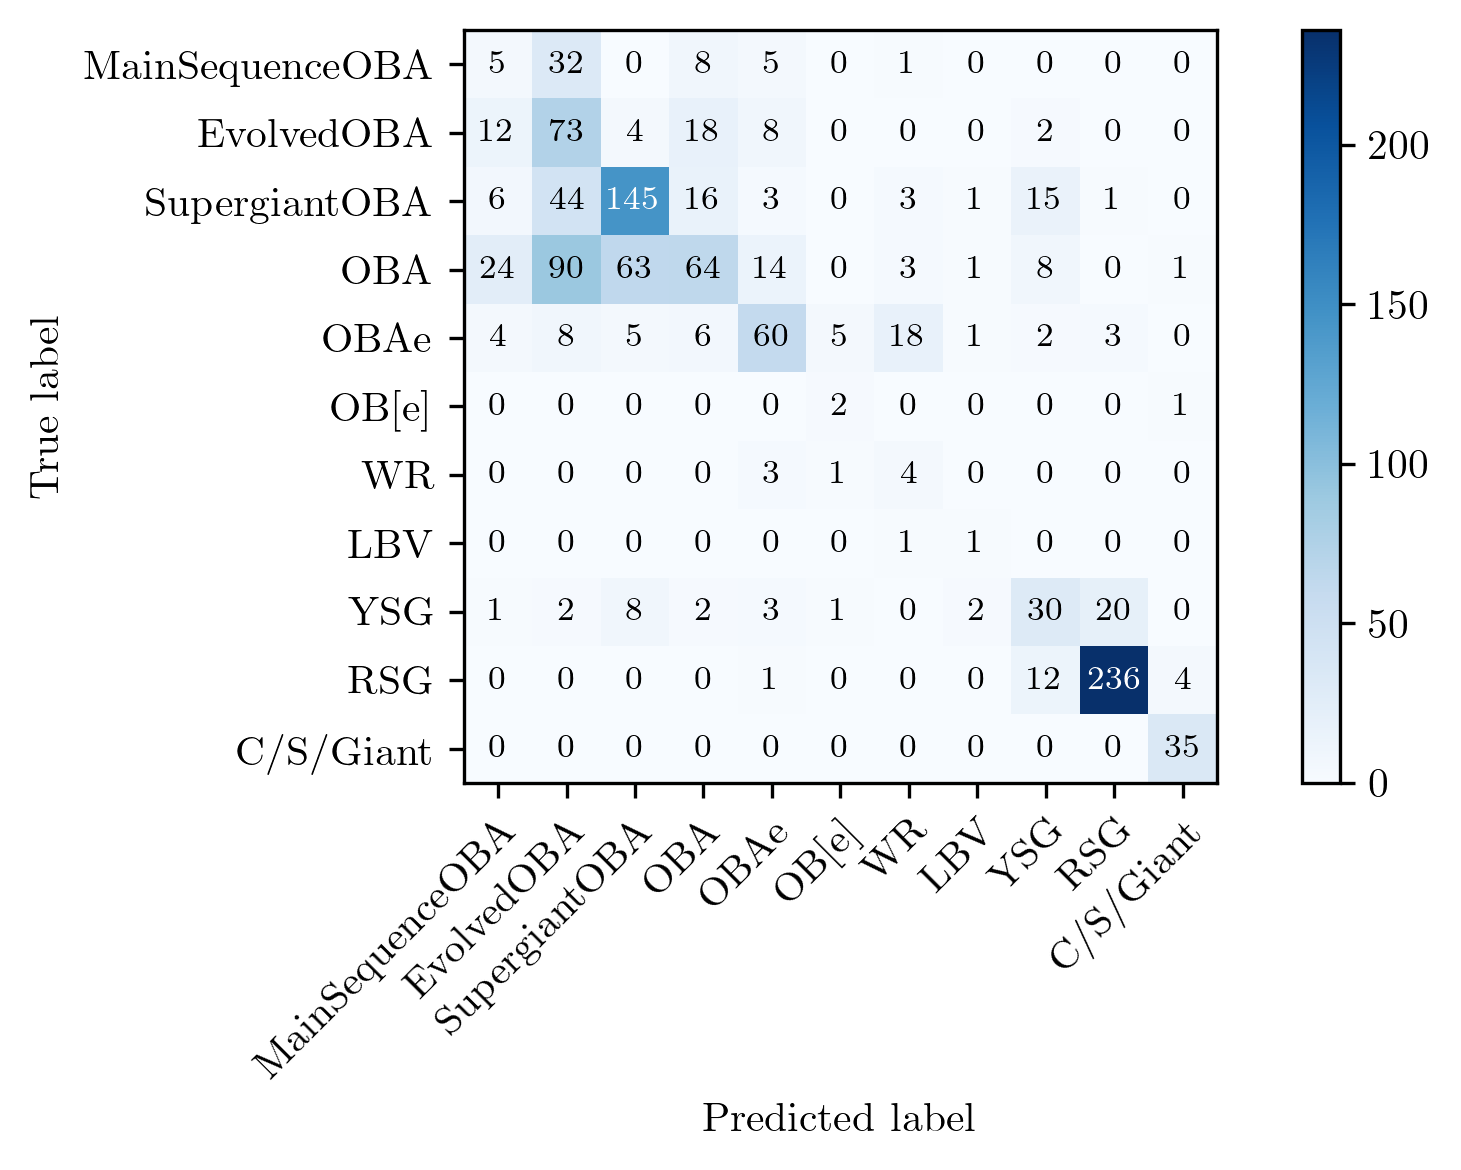

In [17]:
fig,ax = plot_confusion_matrix(y_test, y_check_seven, classes=classes, normalize=False);
fig.dpi = 300
ax.set_title('')
plt.tight_layout()
plt.savefig('../plots/raw_matrix_SVC_best_features.pdf');

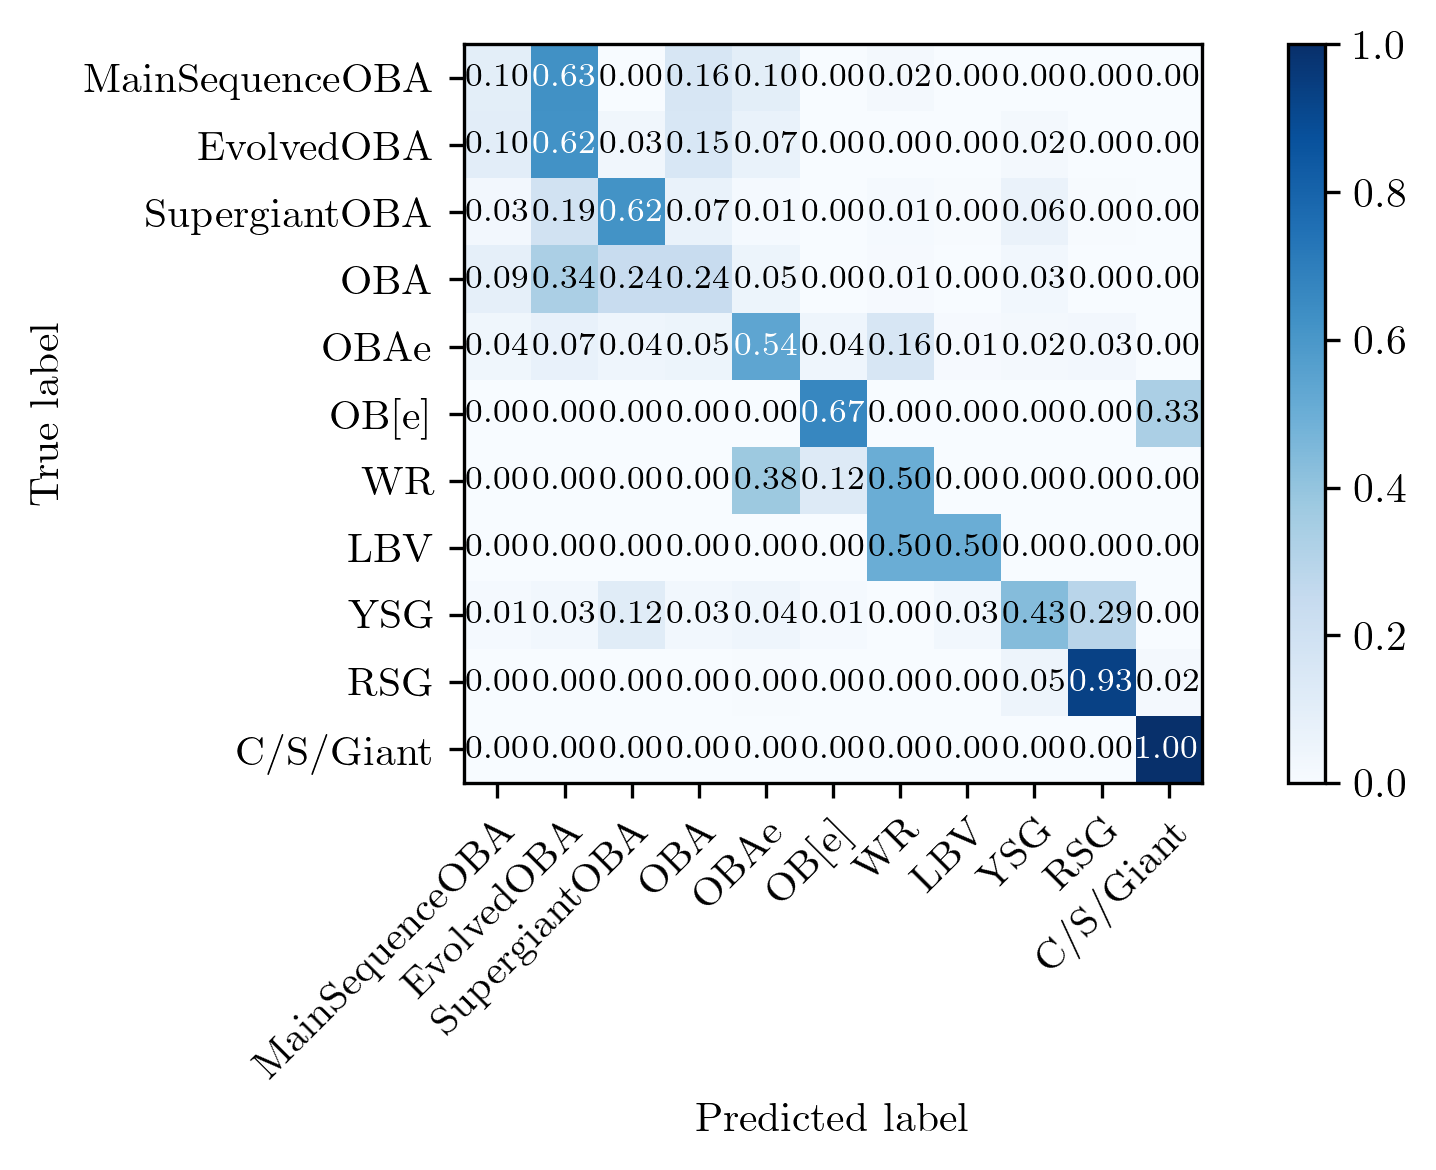

In [18]:
fig,ax = plot_confusion_matrix(y_test, y_check_seven, classes=classes, normalize=True);
fig.dpi = 300
ax.set_title('')
plt.tight_layout()
plt.savefig('../plots/confusion_SVC_best_features.pdf');

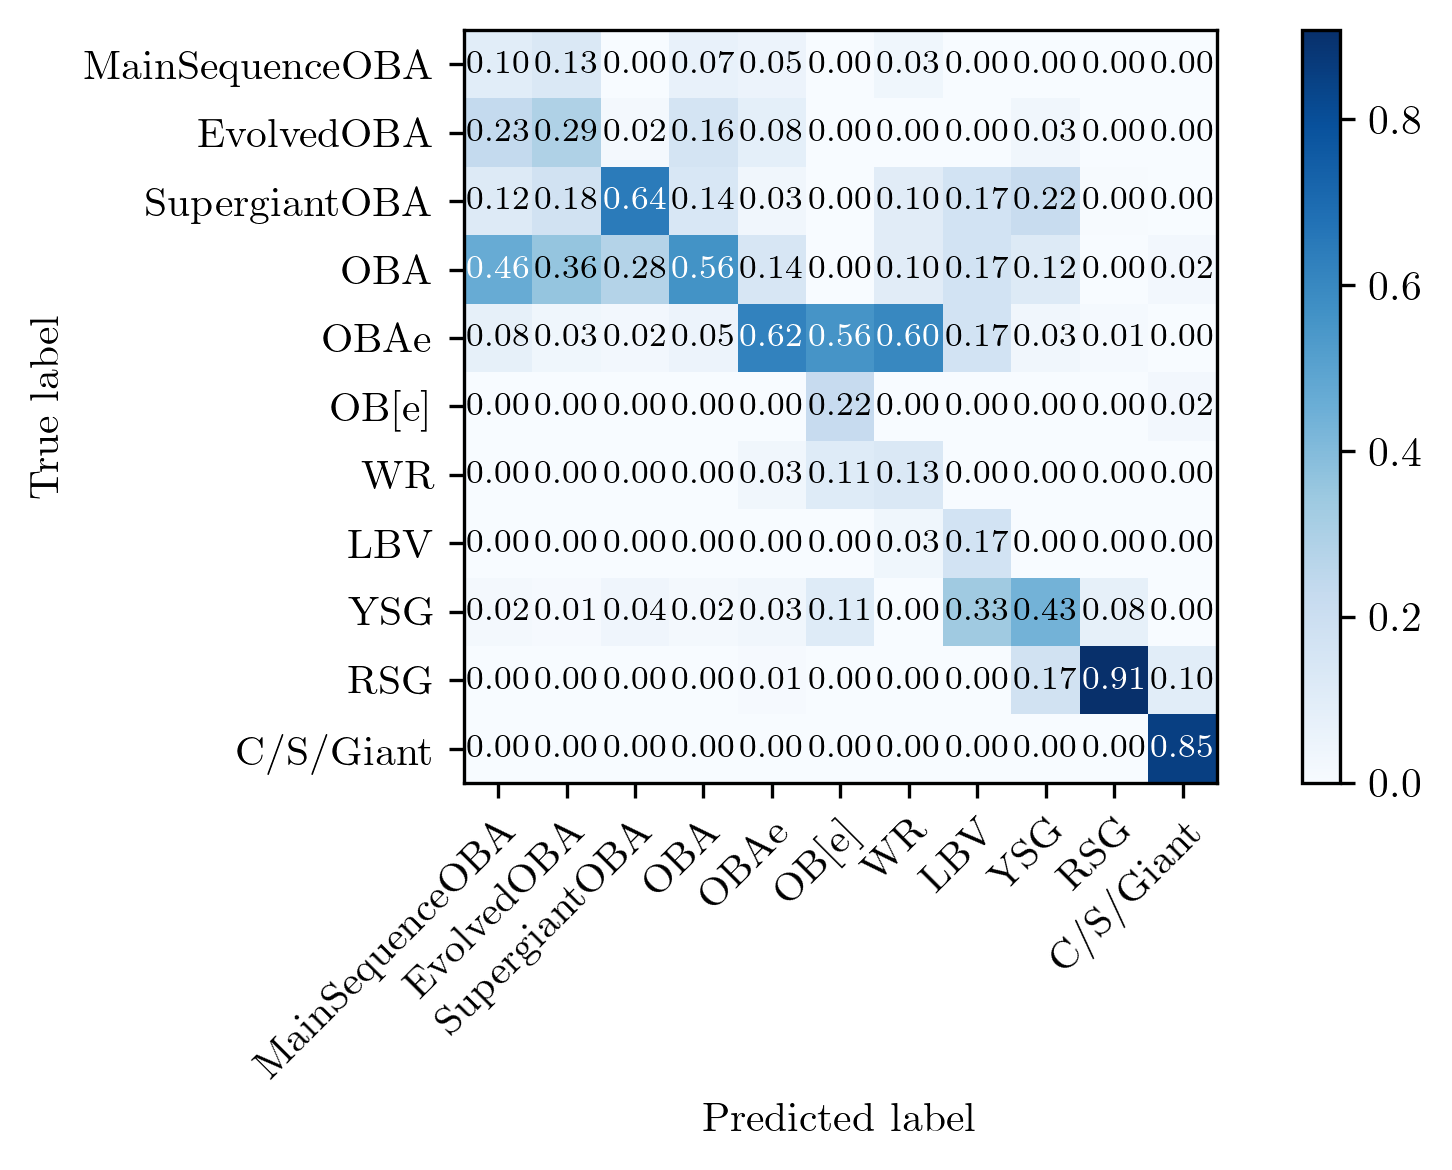

In [19]:
fig,ax = plot_confusion_matrix(y_test, y_check_seven, classes=classes, normalize=True, normalize_axis=0);
fig.dpi = 300
ax.set_title('')
plt.tight_layout()
plt.savefig('../plots/efficiency_SVC_best_features.pdf');

# How does this perform with very coarse labels?

In [15]:
#split into train and test, same random seed
_, _, y_train_c, y_test_c = train_test_split(X, y_c,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=0)

svc_c = SVC(class_weight='balanced')
grid_c = GridSearchCV(svc_c, param_grid, cv=5, n_jobs=-1, verbose=10, error_score=-1e10)
grid_c.fit(X_train_scale, y_train_c)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:    4.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.9s finished
/Users/carina/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed

GridSearchCV(cv=5, error_score=-10000000000.0,
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': array([ 0.01      ,  0.1       ,  1.        , 10.        ,  0.04166667]),
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [16]:
best_svc_c = grid_c.best_estimator_
print(grid_c.best_params_)

{'C': 1, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}


In [17]:
best_svc_c.fit(X_train_scale,y_train_c)
y_check_SVC_c = best_svc_c.predict(X_test_scale)

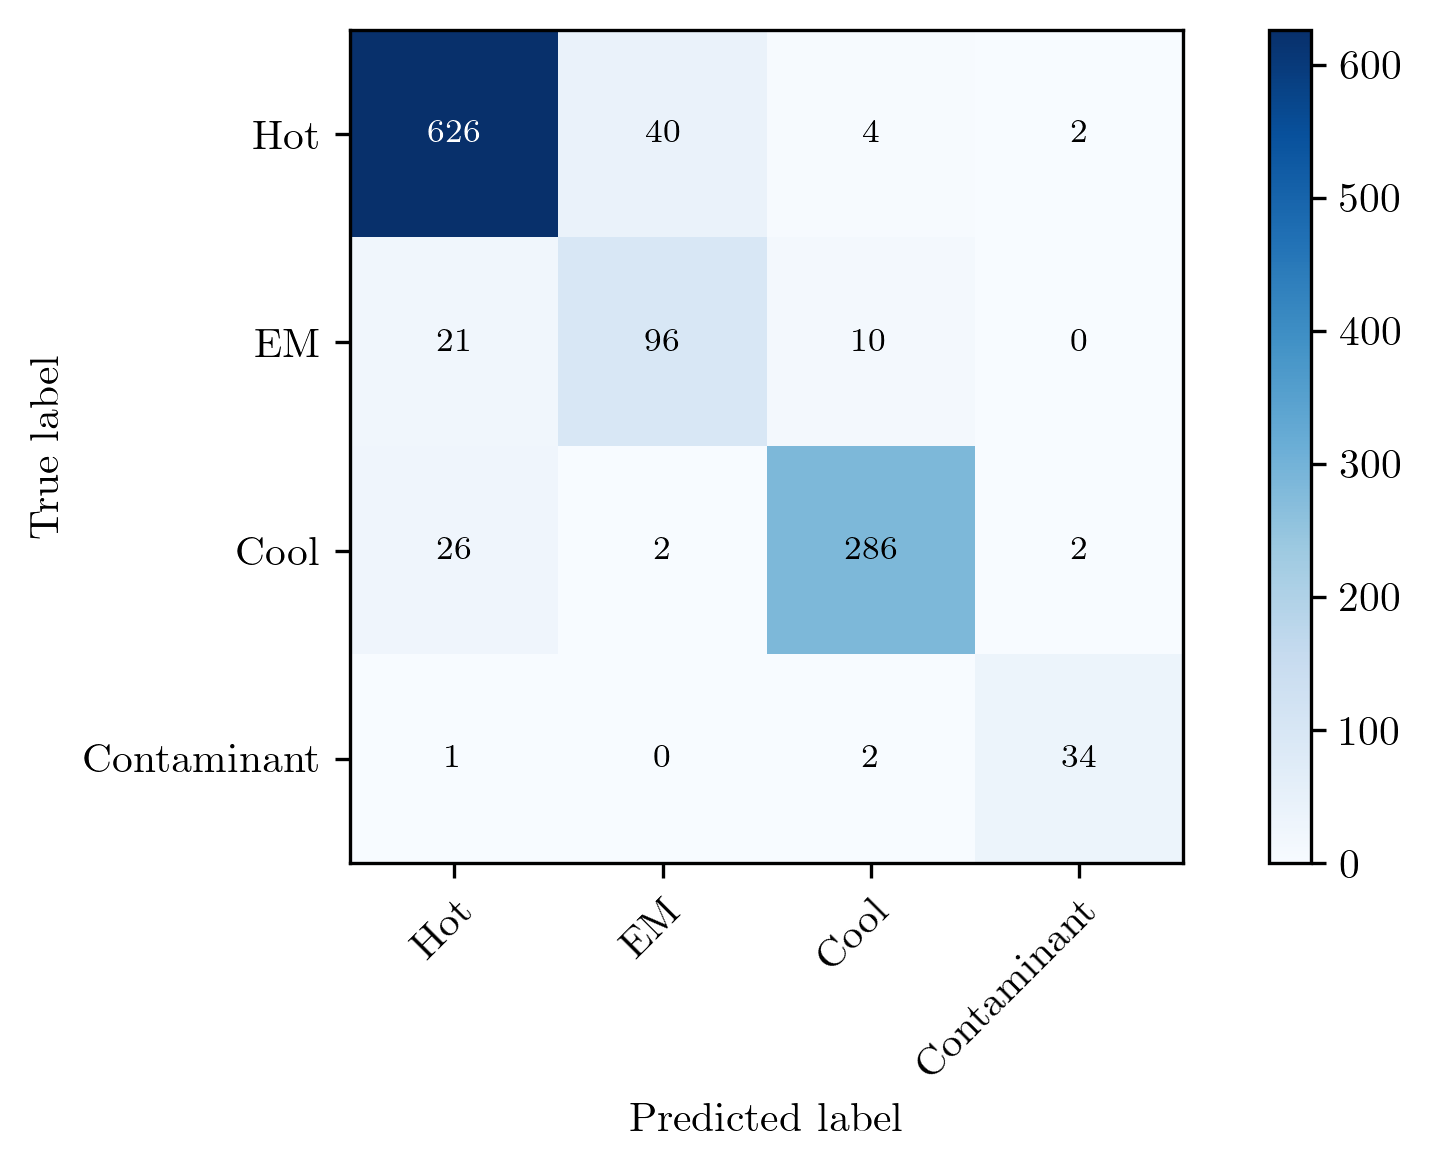

In [18]:
classes_c = ['Hot','EM','Cool','Contaminant']

fig,ax = plot_confusion_matrix(y_test_c, y_check_SVC_c, classes=classes_c, normalize=False);
fig.dpi = 300
ax.set_title('')
plt.tight_layout()
plt.savefig('../plots/raw_matrix_SVC_coarse.pdf');

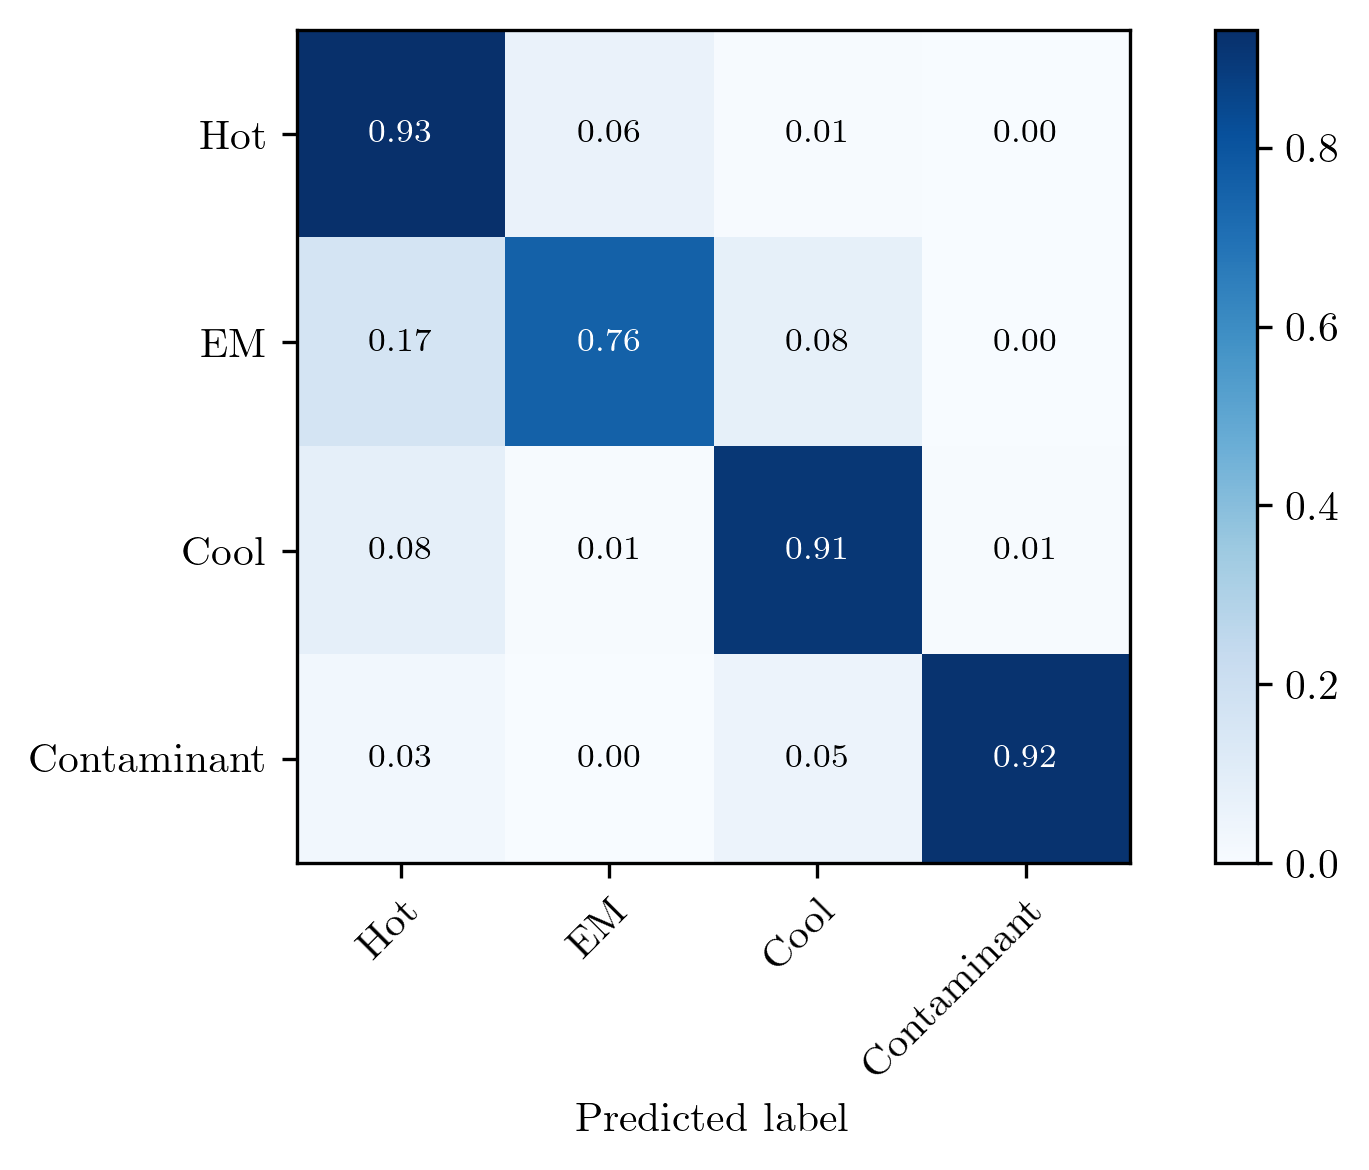

In [19]:
fig,ax = plot_confusion_matrix(y_test_c, y_check_SVC_c, classes=classes_c, normalize=True);
fig.dpi = 300
ax.set_title('')
plt.ylabel('')
plt.tight_layout()
plt.ylabel('')
plt.savefig('../plots/confusion_SVC_coarse.pdf');

In [20]:
found_ems = y_test[(y_test_c == y_check_SVC_c)&(y_test_c=='EM')]
for lab in np.unique(found_ems):
    print(lab,len(found_ems[found_ems==lab]),len(y_test[y_test==lab]),len(found_ems[found_ems==lab])/len(y_test[y_test==lab]))

LBV 2 2 1.0
OBAe 83 113 0.7345132743362832
OB[e] 3 4 0.75
WR 8 8 1.0


In [21]:
missed_ems = y_test[(y_test_c != y_check_SVC_c)&(y_test_c=='EM')]
for lab in np.unique(missed_ems):
    print(lab,len(missed_ems[missed_ems==lab]))#,len(y_test[y_test==lab]),len(found_ems[found_ems==lab])/len(y_test[y_test==lab]))

OBAe 30
OB[e] 1


In [22]:
false_contaminants = y_test[(y_test_c != y_check_SVC_c)&(y_check_SVC_c=='Contaminant')]
for lab in np.unique(false_contaminants):
    print(lab,len(false_contaminants[false_contaminants==lab]))#,len(y_test[y_test==lab]),len(found_ems[found_ems==lab])/len(y_test[y_test==lab]))

OBA 2
RSG 2


In [23]:
missed_contaminants = y_test[(y_test_c != y_check_SVC_c)&(y_test_c=='Contaminant')]
for lab in np.unique(missed_contaminants):
    print(lab,len(missed_contaminants[missed_contaminants==lab]))#,len(y_test[y_test==lab]),len(found_ems[found_ems==lab])/len(y_test[y_test==lab]))

C/S/Giant 1
Yellow Dwarf 2


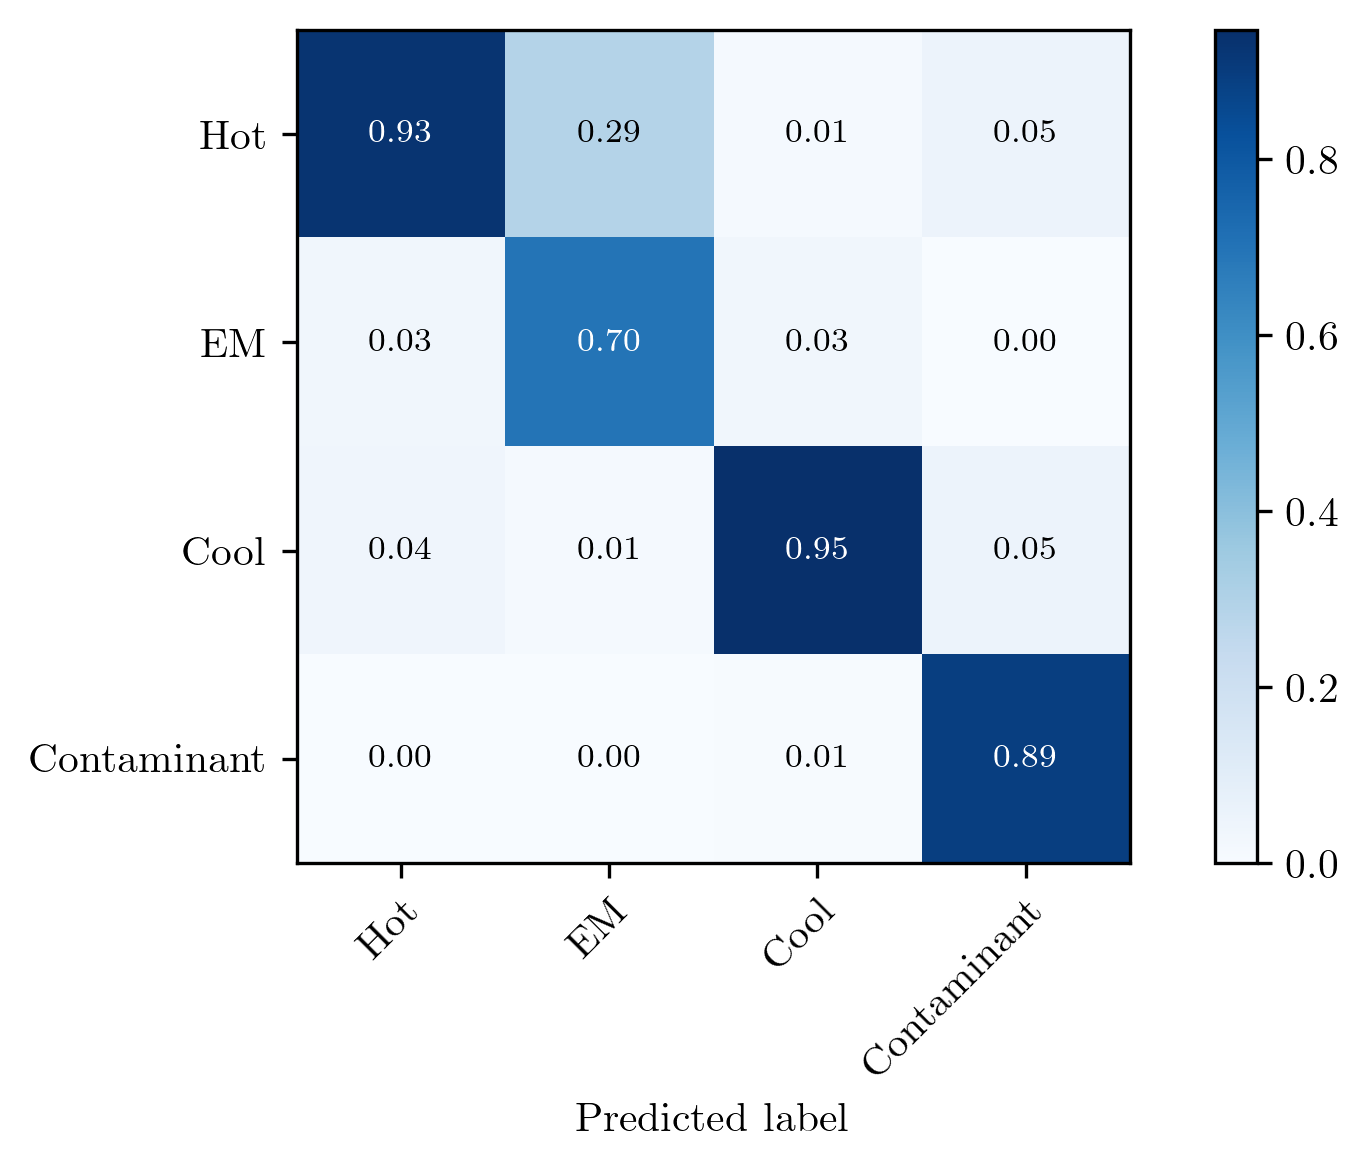

In [24]:
fig,ax = plot_confusion_matrix(y_test_c, y_check_SVC_c, classes=classes_c, normalize=True, normalize_axis=0);
fig.dpi = 300
ax.set_title('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('../plots/efficiency_SVC_coarse.pdf');

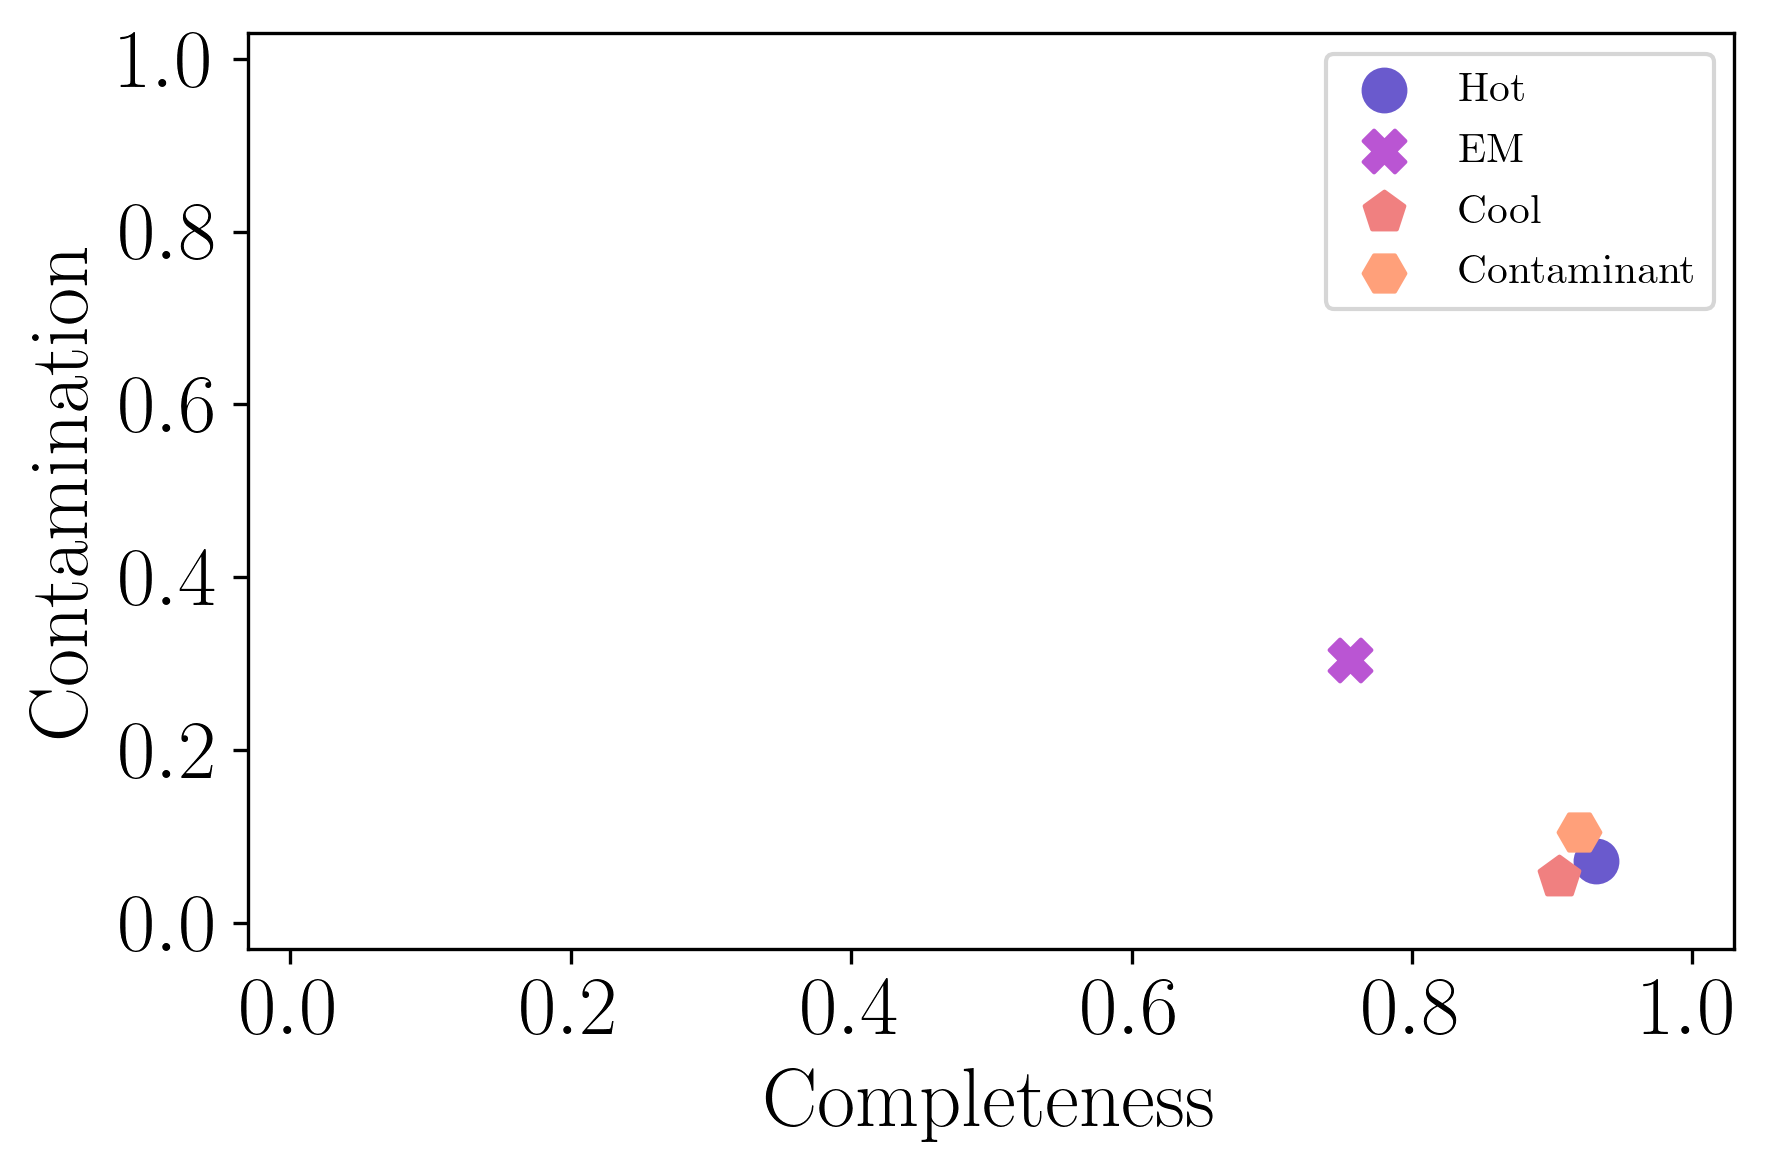

In [25]:
m_dict = {'Hot':'o','EM':'X','Cool':'p','Contaminant':'H'}
c_dict = {'Hot':'slateblue','EM':'mediumorchid','Cool':'lightcoral','Contaminant':'lightsalmon'}

fig,ax = plot_completeness_contamination(y_test_c, y_check_SVC_c, classes=classes_c,c_dict=c_dict,m_dict=m_dict,s=100)
fig.dpi=300
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xlim(-0.03,1.03)
ax.set_ylim(-0.03,1.03)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
fig.tight_layout()
plt.savefig('../plots/completeness_contamination_SVC_coarse.pdf')

Hot
2472
EM
14
Cool
63
Contaminant
1


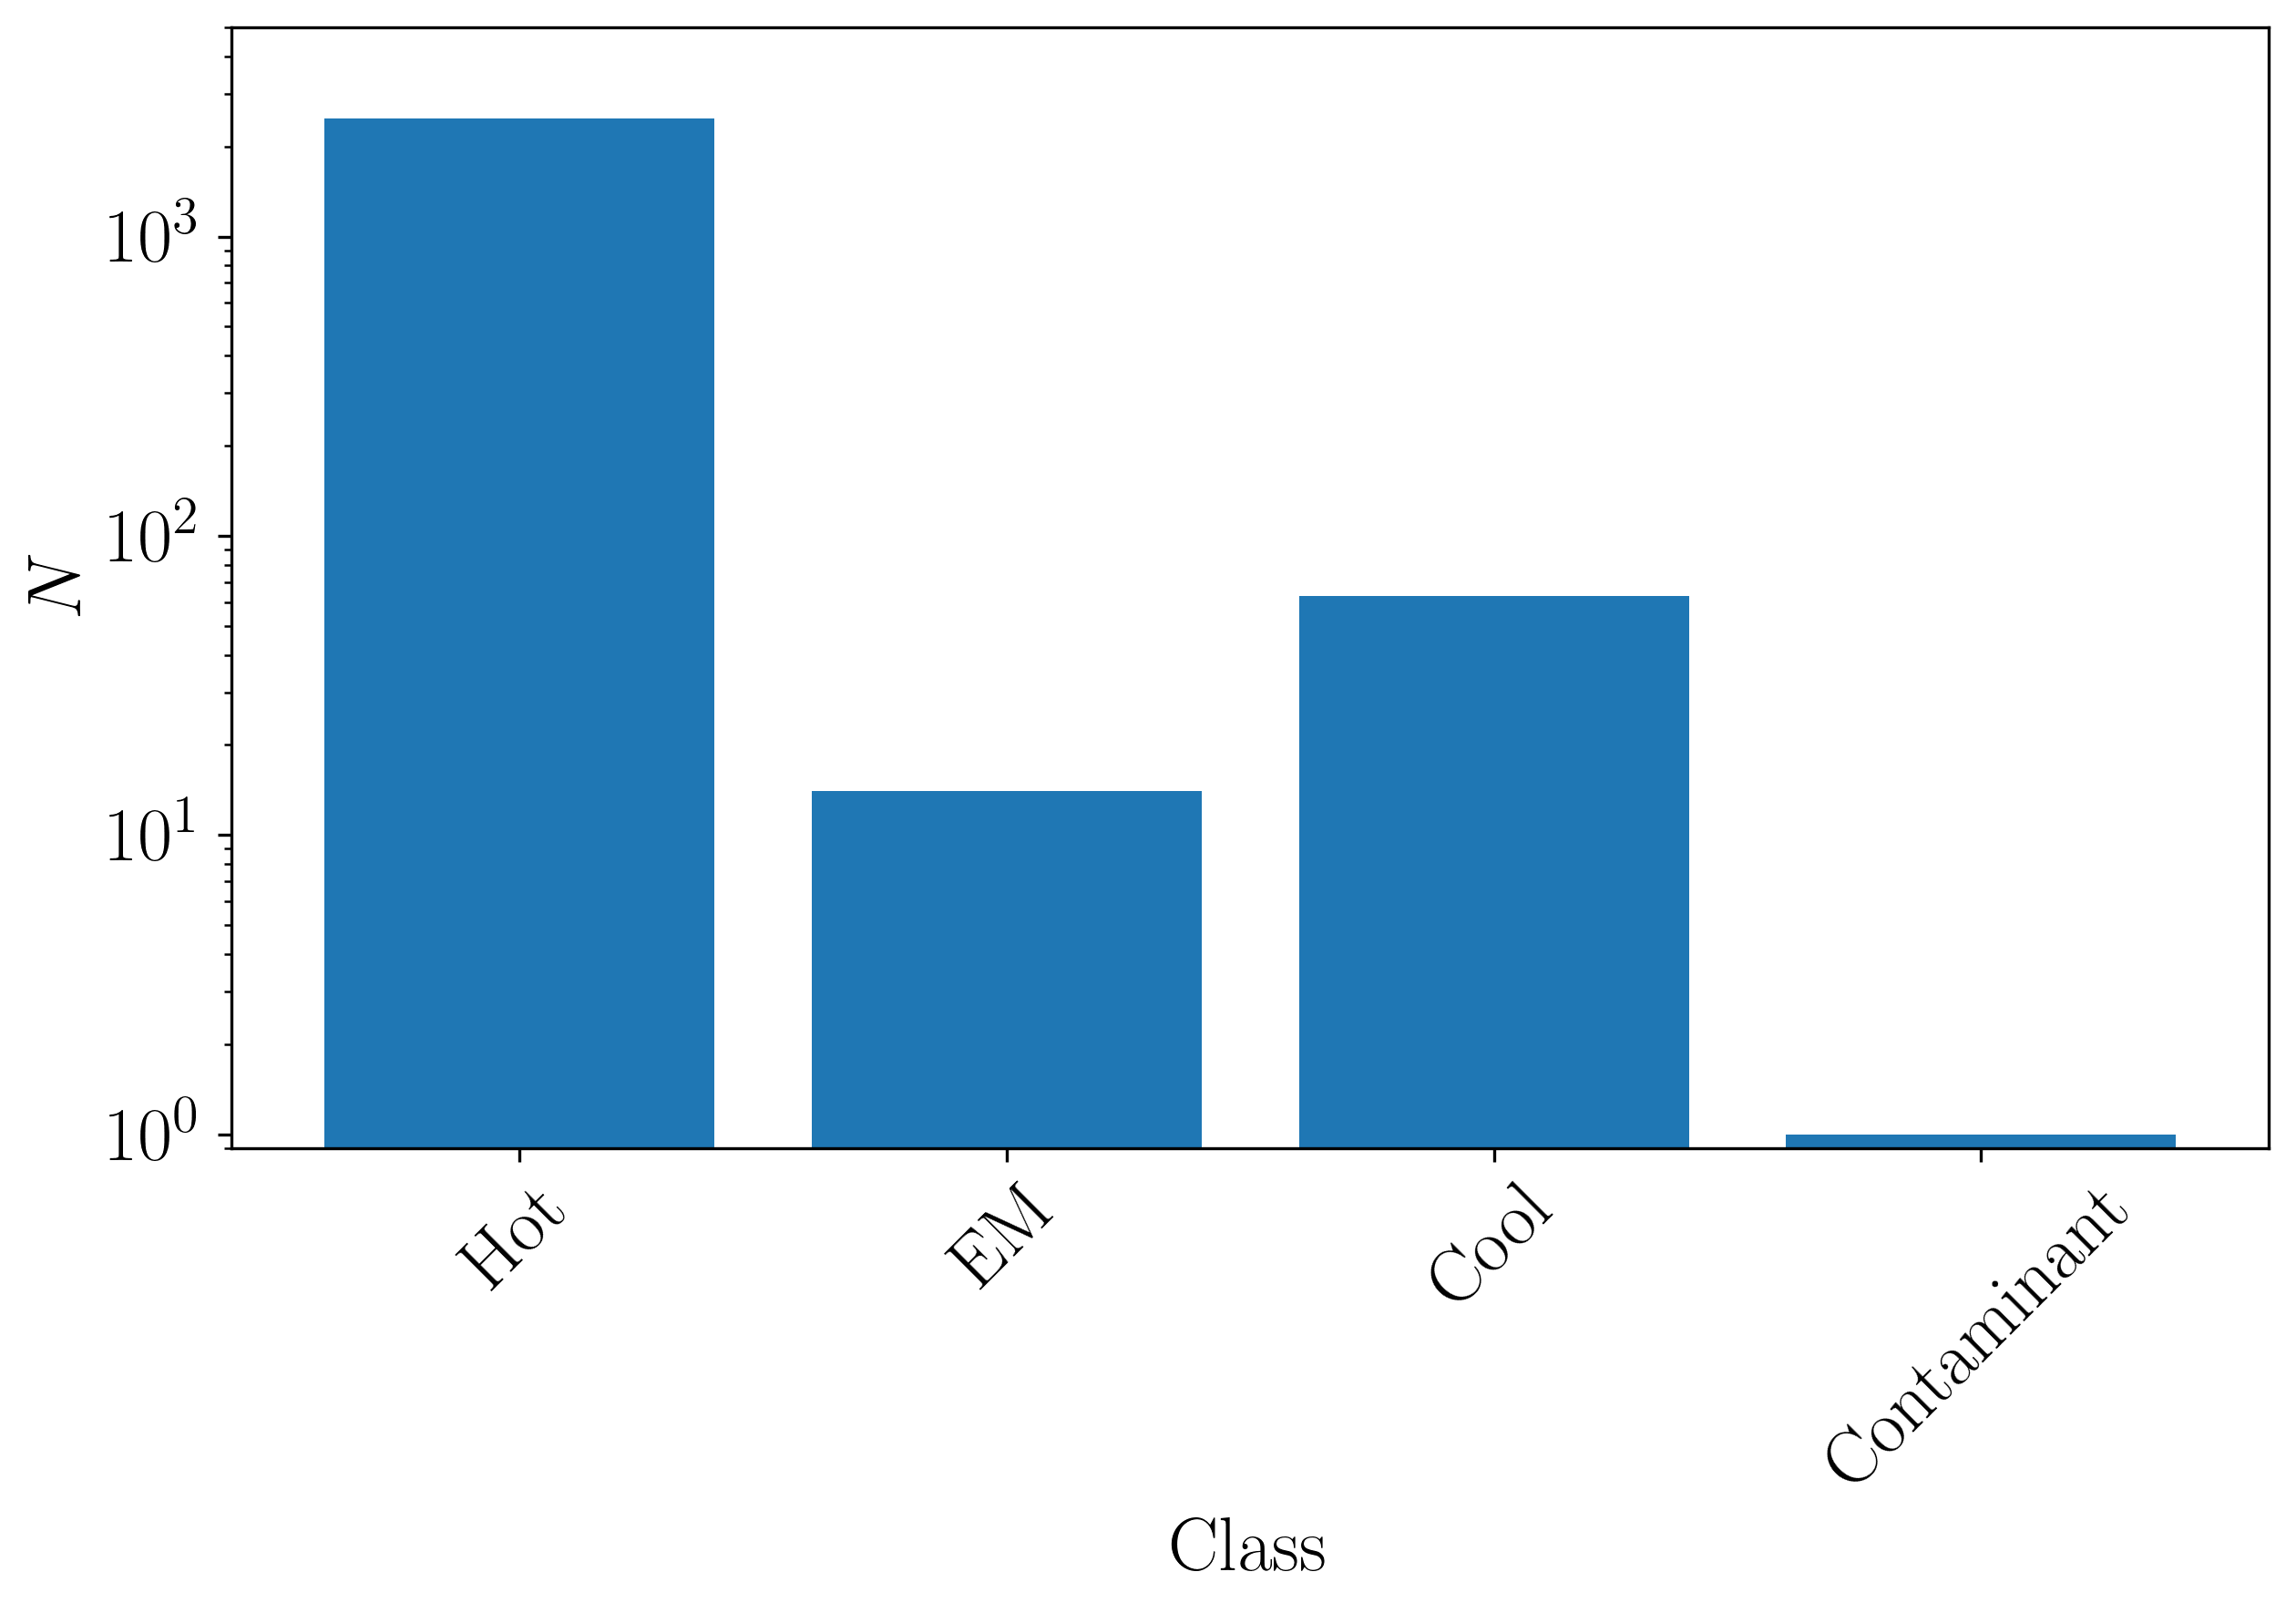

In [26]:
#refit on the whole data set

plt.figure(dpi=300,figsize=(8.5,6))
#best_svc_c.fit(X_scale, y_c)
unknown_classes_c = best_svc_c.predict(X_unknown)
num_output = []
for pred_class in classes_c:
    print(pred_class)
    num = len(unknown_classes_c[unknown_classes_c == pred_class])
    print(num)
    num_output.append(num)
plt.bar(np.arange(len(classes_c)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(classes_c)),labels=classes_c,rotation=45)
plt.xlabel('Class',fontsize=20)
plt.ylabel('$N$',fontsize=20)
plt.ylim(0.9,5000)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/unknown_labels_coarse.pdf')

In [60]:
pred_EM = unknowns[unknown_classes_c=='Cool']
#names = unknowns['CommonName_x'][unknown_classes=='OBAe'].values

for i,row in pred_EM.reset_index(drop=True).iterrows():
    print(i,row['CommonName_x'],row['SpT'],row['MKType'],row['SimbadOType'])

0 TYC 7906-333-1 0 0 Star
1 WISEJ091206.31-533545.3 0 0 0
2 WISEJ185608.58-163255.1 0 0 0
3 W61 19-14 0 0 Star
4 OGLE BRIGHT-LMC-MISC-169 0 0 Star
5 WISEJ194127.64+385155.3 0 0 0
6 Cl* NGC 2004   BBBC     431 0 0 *inCl
7 [KWV2015] J045626.51-692350.6 0 0 Star
8 W61  6-54 0 0 *inCl
9 W61  6-34 0 0 LPV*
10 W61  6-65 0 0 LPV*
11 Cl* NGC 2004      E      33 0 0 *inCl
12 [MG73]  80 0 0 Star
13 W61  6-69 0 0 *inCl
14 Cl* NGC 2004    ROB B45 0 0 Star
15 W61  6-46 0 0 Star
16 WISEJ045655.01-693312.0 0 0 0
17 WISEJ051341.58-671209.4 0 0 0
18 WISEJ050911.17-655205.7 0 0 0
19 OGLE BRIGHT-LMC-MISC-545 0 0 Star
20 2MASS J05241617-6939310 0 0 Star
21 WISEJ164905.67-290748.2 0 0 0
22 WISEJ054315.11-671749.1 0 0 0
23 MACHO  53.3728.12 0 0 Star
24 WISEJ053329.59-670413.9 0 0 0
25 SV* HV  2231 0 0 deltaCep
26 WISEJ005352.82-713757.4 0 0 0
27 MACHO   7.8140.13 0 0 Star
28 SP77  55-7 0 0 Star
29 OGLE BRIGHT-LMC-MISC-378 0 0 Star
30 MACHO  79.4659.3349 0 0 Star
31 WISEJ050324.56-662302.8 0 0 0
32 WISEJ0455

In [32]:
column_dict = {i:col for i,col in zip(range(len(X.columns)),X.columns)}
index_dict = {col:i for i,col in zip(range(len(X.columns)),X.columns)}

test_svc_c = SVC(class_weight='balanced',kernel='rbf',C=1,gamma=1/X_scale.shape[1])

best_columns_c = np.array([])
best_indices_c = np.array([],dtype=int)
best_scores_c = np.array([])
best_stds_c = np.array([])

while len(best_columns_c) != len(X.columns):
    test_indices = best_indices_c.copy() #current set of used indices
    trial_indices = []
    trial_scores = []
    trial_stds = []
    for i in range(len(X.columns)): #for every feature
        if i not in best_indices_c: #if we aren't already using that feature...
            test_indices = np.append(test_indices,i) #add it to the list...
            subset_train = X_train_scale[:,test_indices] #grab the training data on those columns
            scores = cross_val_score(test_svc_c, subset_train, y_train_c, cv=5, scoring='balanced_accuracy', 
                                    n_jobs=-1, error_score=-1e10) #balanced accuracy over 5 stratefied folds
            
            trial_indices.append(i)
            trial_scores.append(scores.mean())
            trial_stds.append(scores.std())
            test_indices = test_indices[:-1]
    next_col = trial_indices[np.argmax(trial_scores)] #grab index that yielded the best accuracy
    best_columns_c = np.append(best_columns_c, column_dict[next_col])
    best_indices_c = np.append(best_indices_c, next_col)
    best_scores_c = np.append(best_scores_c, max(trial_scores))
    best_stds_c = np.append(best_stds_c, trial_stds[np.argmax(trial_scores)])
    print(len(best_columns_c))


1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24


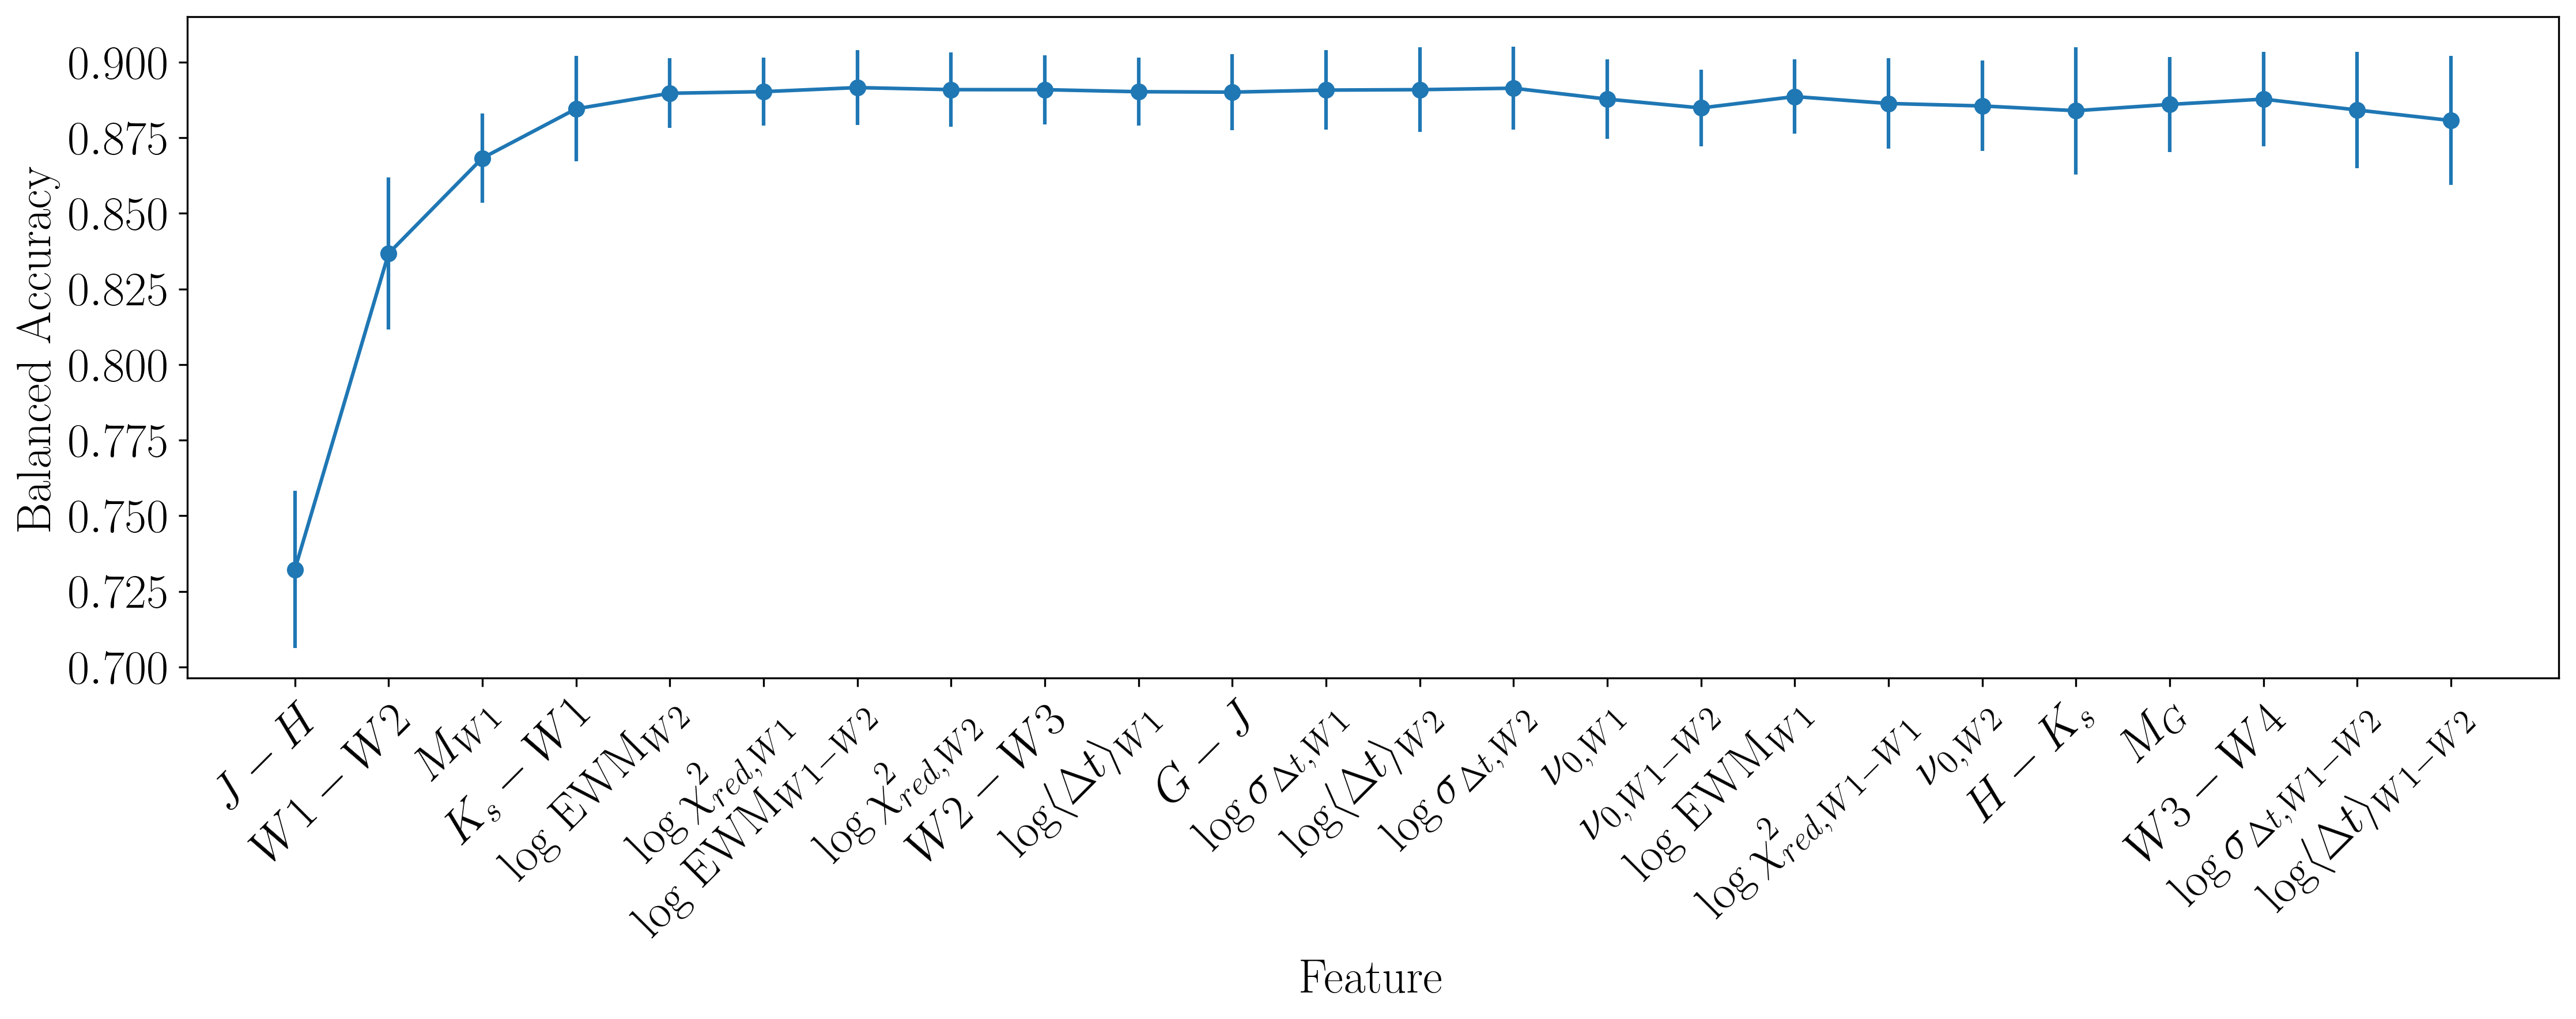

In [33]:
all_cols = ['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1logchi2red','W1_logEWM','W1_Nzeroes',
                   'W1_log_meanDt', 'W1_log_stdDt','W2logchi2red','W2_logEWM','W2_Nzeroes', 'W2_log_meanDt',
                   'W2_log_stdDt','W1-W2logchi2red','W1-W2_logEWM','W1-W2_Nzeroes','W1-W2_log_meanDt','W1-W2_log_stdDt']
var_names = ['$M_G$','$G-J$','$J-H$','$H-K_s$','$K_s-W1$','$W1-W2$','$W2-W3$','$W3-W4$','$M_{W1}$',r'$\log\chi^2_{red,W1}$',
             r'$\log$ EWM$_{W1}$',r'$\nu_{0,W1}$',r'$\log\langle \Delta t \rangle_{W1}$',
             r'$\log\sigma_{\Delta t,W1}$',r'$\log\chi^2_{red,W2}$',r'$\log$ EWM$_{W2}$',r'$\nu_{0,W2}$',
             r'$\log\langle \Delta t \rangle_{W2}$',r'$\log\sigma_{\Delta t,W2}$',r'$\log\chi^2_{red,W1-W1}$',
             r'$\log$ EWM$_{W1-W2}$',r'$\nu_{0,W1-W2}$',r'$\log\langle \Delta t \rangle_{W1-W2}$',
             r'$\log\sigma_{\Delta t,W1-W2}$','Class']
var_dict = {col:var for col,var in zip(all_cols,var_names)}

fig = plt.figure(dpi=300,figsize=(15,6))
ax=plt.gca()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.errorbar(np.arange(len(X.columns)),best_scores_c,yerr=best_stds_c,fmt='-o')
plt.xticks(ticks=np.arange(len(X.columns)),labels=[var_dict[col] for col in best_columns_c],rotation=45,ha="right",
             rotation_mode="anchor")
plt.xlabel('Feature')
plt.ylabel('Balanced Accuracy')
fig.tight_layout()
plt.savefig('../plots/feature_importance_svc_coarse.pdf')

In [34]:
[var_dict[col] for col in best_columns_c][np.argmax(best_scores_c)]

'$\\log$ EWM$_{W1-W2}$'

In [35]:
def fbeta_class(y_true, y_pred, beta=1.0, label=None):
    if label is not None:
        if (label in y_true):
            completeness = len(y_true[(y_pred==y_true)&(y_true==label)])/len(y_true[y_true==label])
        else:
            raise ValueError('label not in true labels')
        if label in y_pred:
            precision = len(y_true[(y_pred==y_true)&(y_true==label)])/len(y_pred[y_pred==label])
        else:
            precision = 0.0
        if (completeness == precision) & (precision == 0):
            return 0.0
        fac1 = 1.0 + beta*beta
        num = completeness*precision
        den = (beta*beta*completeness) + precision
        return fac1 * num / den
    else:
        raise ValueError('please give label')

In [36]:
def greedy_search_label_fbeta(label,X,y,beta=2,max_features=len(X.columns),class_weight='balanced',kernel='rbf',C=1,gamma=1/X_scale.shape[1]):
    test_svc_c = SVC(class_weight=class_weight,kernel=kernel,C=C,gamma=gamma)

    best_columns_c = np.array([])
    best_indices_c = np.array([],dtype=int)
    best_scores_c = np.array([])
    best_stds_c = np.array([])
    
    fbeta = make_scorer(fbeta_class, beta=beta, label=label)
    
    while len(best_columns_c) != max_features:
        test_indices = best_indices_c.copy() #current set of used indices
        trial_indices = []
        trial_scores = []
        trial_stds = []
        for i in range(max_features): #for every feature
            if i not in best_indices_c: #if we aren't already using that feature...
                test_indices = np.append(test_indices,i) #add it to the list...
                subset_train = X[:,test_indices] #grab the training data on those columns
                scores = cross_val_score(test_svc_c, subset_train, y, cv=5, scoring=fbeta, 
                                        n_jobs=-1, error_score=-1e10) #f_2 over 5 stratefied folds

                trial_indices.append(i)
                trial_scores.append(scores.mean())
                trial_stds.append(scores.std())
                test_indices = test_indices[:-1]
        next_col = trial_indices[np.argmax(trial_scores)] #grab index that yielded the best accuracy
        best_columns_c = np.append(best_columns_c, column_dict[next_col])
        best_indices_c = np.append(best_indices_c, next_col)
        best_scores_c = np.append(best_scores_c, max(trial_scores))
        best_stds_c = np.append(best_stds_c, trial_stds[np.argmax(trial_scores)])
        print(len(best_columns_c))
        
    return best_columns_c,best_indices_c,best_scores_c,best_stds_c

In [39]:
best_columns_em,best_indices_em,best_scores_em,best_stds_em = greedy_search_label_fbeta('EM',X_train_scale,y_train_c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


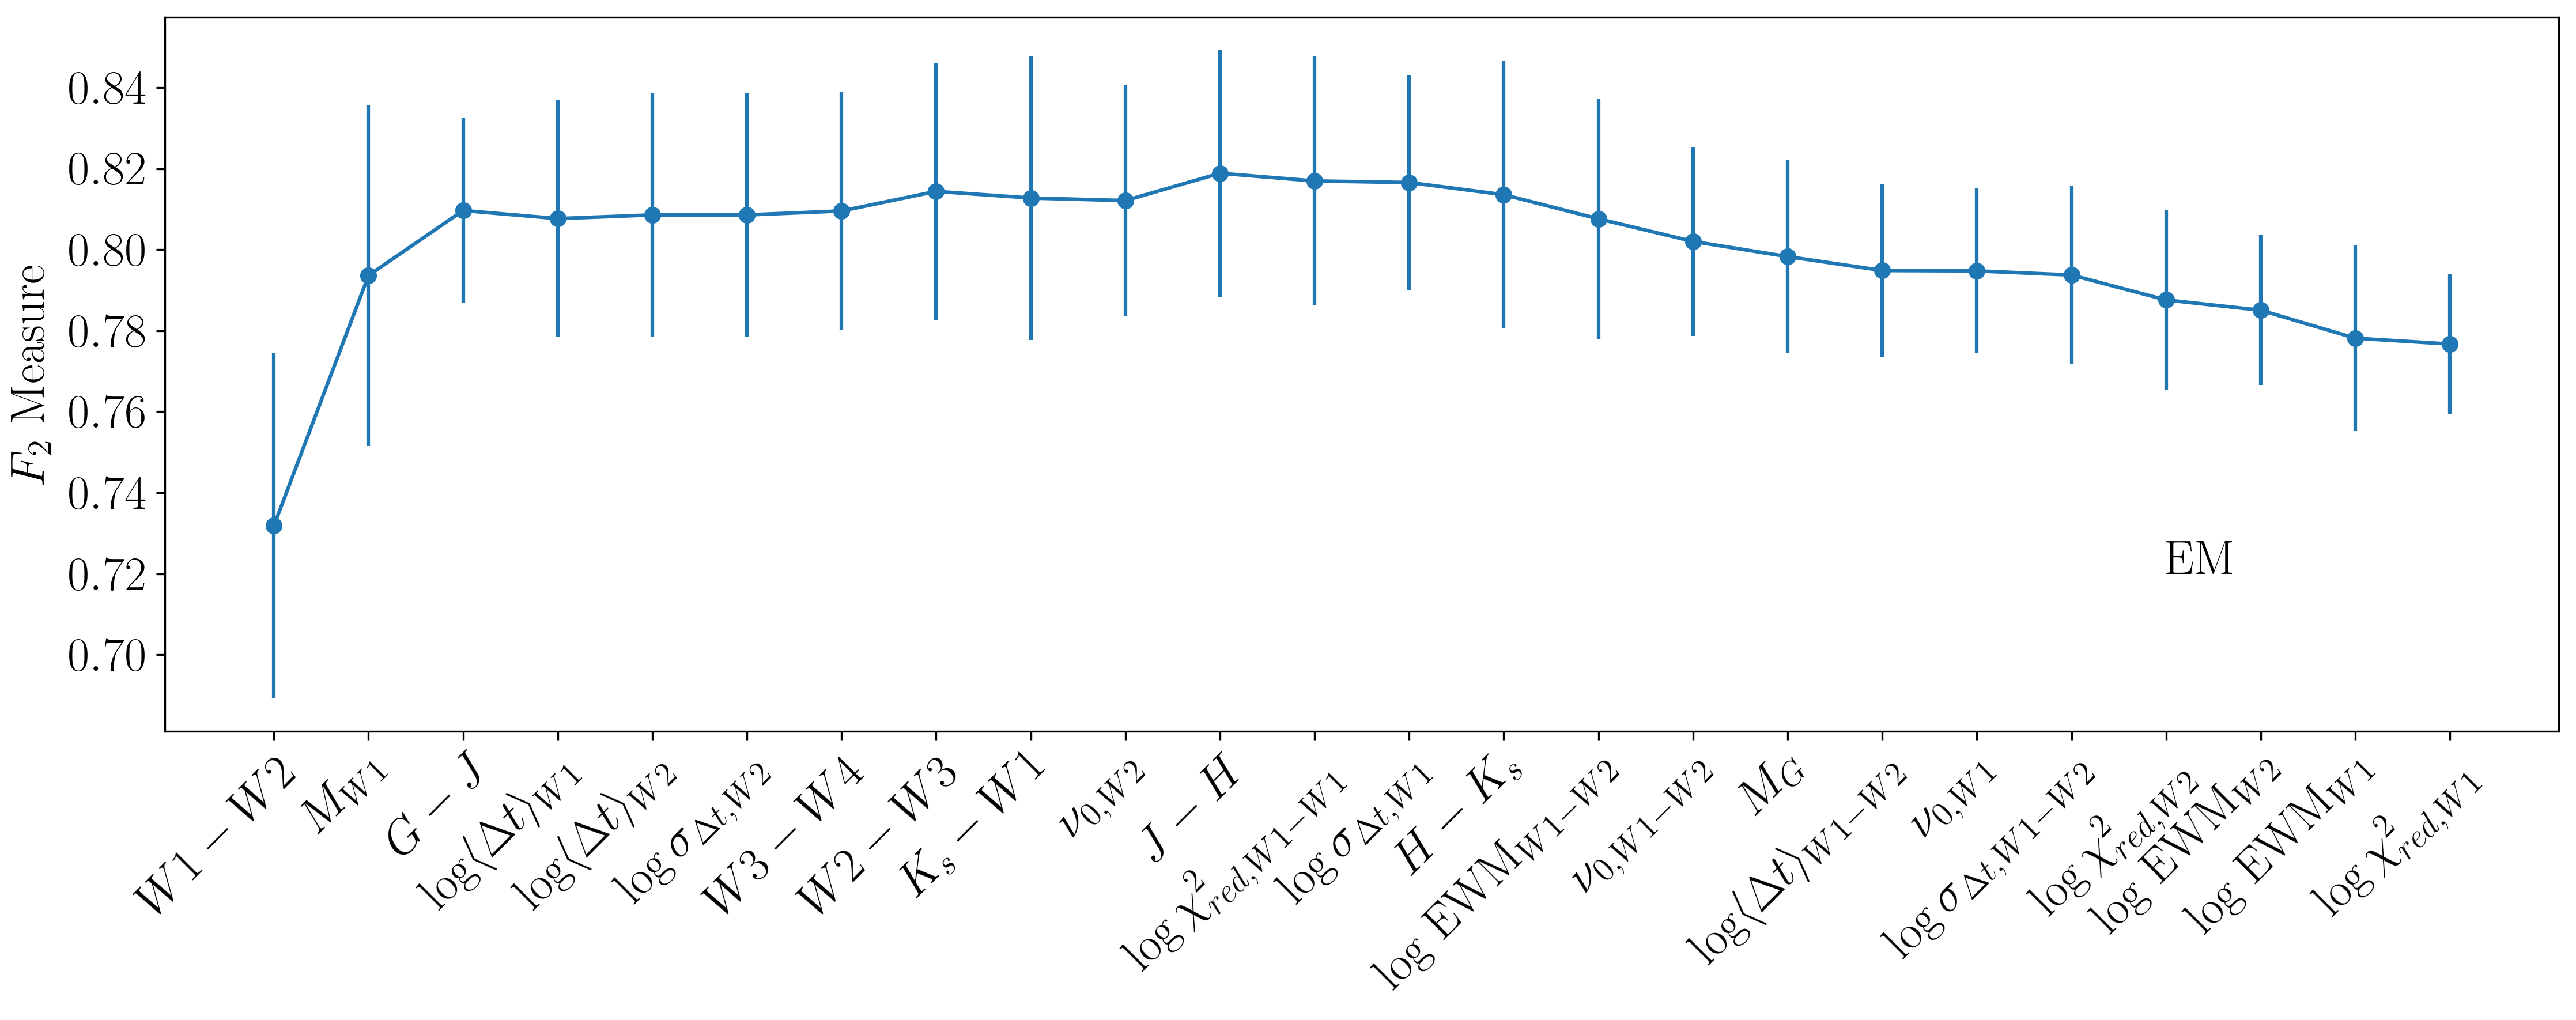

In [45]:
fig = plt.figure(dpi=300,figsize=(15,6))
ax=plt.gca()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.errorbar(np.arange(len(X.columns)),best_scores_em,yerr=best_stds_em,fmt='-o')
plt.xticks(ticks=np.arange(len(X.columns)),labels=[var_dict[col] for col in best_columns_em],rotation=45,ha="right",
             rotation_mode="anchor")
plt.xlabel('')
plt.ylabel('$F_2$ Measure')
plt.text(20,0.72,'EM',fontsize=20)
fig.tight_layout()
plt.savefig('../plots/feature_importance_svc_em.pdf')

In [50]:
[var_dict[col] for col in best_columns_em][np.argmax(best_scores_em)]

'$J-H$'

In [41]:
best_columns_con,best_indices_con,best_scores_con,best_stds_con = greedy_search_label_fbeta('Contaminant',X_train_scale,y_train_c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


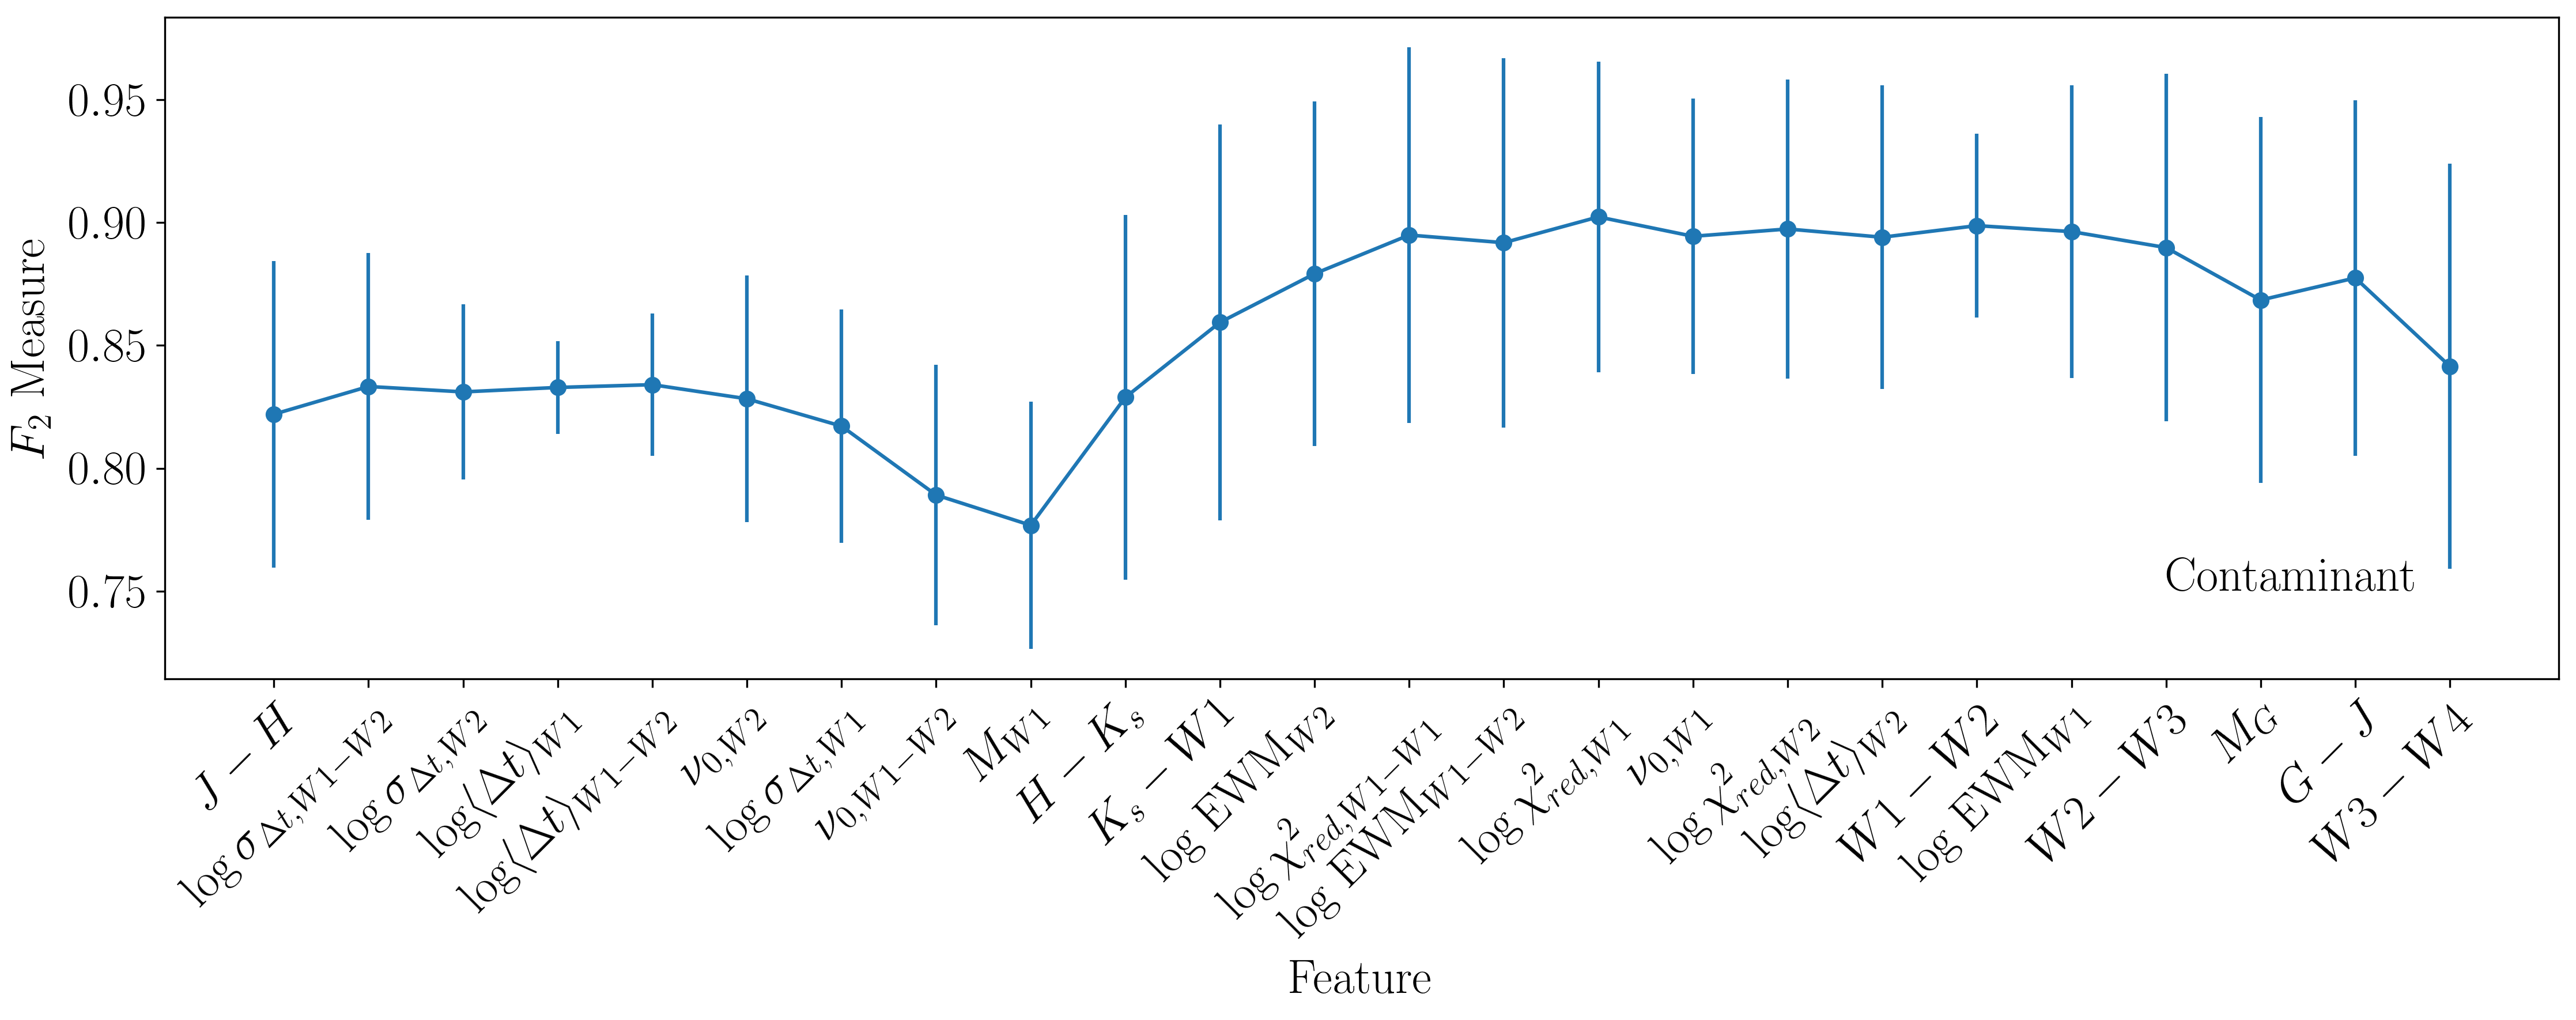

In [48]:
fig = plt.figure(dpi=300,figsize=(15,6))
ax=plt.gca()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.errorbar(np.arange(len(X.columns)),best_scores_con,yerr=best_stds_con,fmt='-o')
plt.xticks(ticks=np.arange(len(X.columns)),labels=[var_dict[col] for col in best_columns_con],rotation=45,ha="right",
             rotation_mode="anchor")
plt.xlabel('Feature')
plt.ylabel('$F_2$ Measure')
plt.text(20,0.75,'Contaminant',fontsize=20)
fig.tight_layout()
plt.savefig('../plots/feature_importance_svc_con.pdf')

In [52]:
out = ''
for i in range(int(np.argmax(best_scores_con))+1):
    out += var_dict[best_columns_con[i]]
    out += ', '
out

'$J-H$, $\\log\\sigma_{\\Delta t,W1-W2}$, $\\log\\sigma_{\\Delta t,W2}$, $\\log\\langle \\Delta t \\rangle_{W1}$, $\\log\\langle \\Delta t \\rangle_{W1-W2}$, $\\nu_{0,W2}$, $\\log\\sigma_{\\Delta t,W1}$, $\\nu_{0,W1-W2}$, $M_{W1}$, $H-K_s$, $K_s-W1$, $\\log$ EWM$_{W2}$, $\\log\\chi^2_{red,W1-W1}$, $\\log$ EWM$_{W1-W2}$, $\\log\\chi^2_{red,W1}$, '

In [ ]:
def plot_decision_surface(col1,col2,label,rev_yax = True,cm = plt.cm.RdBu_r,cm_bright = ListedColormap(['#FF0000', '#0000FF'])):
    col1_id = np.where(X.columns.values == col1)[0][0]
    col2_id = np.where(X.columns.values == col2)[0][0]
    label_id = encoder.transform([label])[0]
    lens = np.ones(X_scale.shape[1])
    lens[col1_id] = 50
    lens[col2_id] = 50
    list_of_bounding_arrays = [np.linspace(col.min()-0.5, col.max()+0.5, l) if l != 1 else np.array([col.mean()]) 
                               for col,l in zip(X_scale.T,lens)]
    X_grid = np.array([list(tup) for tup in tqdm(itertools.product(*list_of_bounding_arrays))])
    
    X_orig = scaler.inverse_transform(X_grid)
    fig, ax = plt.subplots()
    # Plot the training points
    ax.scatter(scaler.inverse_transform(X_train)[:, col1_id], scaler.inverse_transform(X_train)[:, col2_id], 
               c=np.clip(np.abs(y_train-label_id), 0, 1), cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(scaler.inverse_transform(X_test)[:, col1_id], scaler.inverse_transform(X_test)[:, col2_id], 
               c=np.clip(np.abs(y_test-label_id), 0, 1), cmap=cm_bright, alpha=0.6, edgecolors='k')
    
    ax.set_xlim(X_orig[:,col1_id].min(), X_orig[:,col1_id].max())
    ax.set_ylim(X_orig[:,col2_id].min(), X_orig[:,col2_id].max())
    if rev_yax:
        ax.invert_yaxis()
    Z = best_svc.decision_function(X_grid)[:,label_id]
    Z = Z.reshape(50,50)
    cf = ax.contourf(np.unique(X_orig[:,col1_id]), np.unique(X_orig[:,col2_id]), Z, cmap=cm, alpha=.5)
    plt.colorbar(mappable=cf)
    return ax

In [ ]:
plot_decision_surface('G-J','M_G','RSG')

In [ ]:
plot_decision_surface('G-J','W1_EWM','RSG',rev_yax=False)

In [ ]:
plot_decision_surface('W2-W3','W1_EWM','RSG',rev_yax=False)

In [ ]:
plot_decision_surface('W2-W3','W1_EWM','LBV',rev_yax=False)